# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.69KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

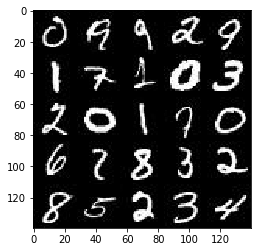

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

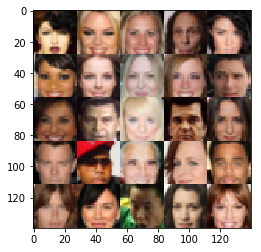

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return real_input, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x channels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', \
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', \
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 x 7 x 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', \
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4 x 4 x 256
        drop = tf.layers.dropout(relu3, rate=0.1, training=not reuse)
        
        # Flatten it
        flat = tf.reshape(drop, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits) 

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    inf = not is_train
    with tf.variable_scope('generator', reuse=inf):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7 x 7 x 256 now
        x2 = tf.layers.dropout(x2, rate=0.5, training=is_train)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14 x 14 x 128 now
        x3 = tf.layers.dropout(x3, rate=0.5, training=is_train)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x out_channel_dim now
        
        out = tf.tanh(logits)    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, learn_rate = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Normalize the images to be between -1.0 and 1.0
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,\
                                                   learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, \
                                                  learn_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 1.1200... Generator Loss: 1.9169
Epoch 1/2... Batch 20... Discriminator Loss: 0.6152... Generator Loss: 3.0618
Epoch 1/2... Batch 30... Discriminator Loss: 0.6957... Generator Loss: 3.8597
Epoch 1/2... Batch 40... Discriminator Loss: 0.9789... Generator Loss: 3.3336
Epoch 1/2... Batch 50... Discriminator Loss: 1.7413... Generator Loss: 0.9543
Epoch 1/2... Batch 60... Discriminator Loss: 1.4919... Generator Loss: 2.0635
Epoch 1/2... Batch 70... Discriminator Loss: 1.7336... Generator Loss: 0.3629
Epoch 1/2... Batch 80... Discriminator Loss: 1.6384... Generator Loss: 0.4108
Epoch 1/2... Batch 90... Discriminator Loss: 1.6661... Generator Loss: 0.4393
Epoch 1/2... Batch 100... Discriminator Loss: 1.2247... Generator Loss: 1.8386


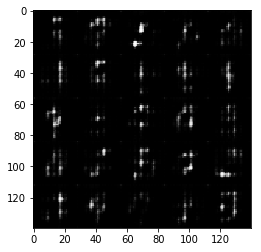

Epoch 1/2... Batch 110... Discriminator Loss: 1.7333... Generator Loss: 0.5049
Epoch 1/2... Batch 120... Discriminator Loss: 0.8852... Generator Loss: 1.0596
Epoch 1/2... Batch 130... Discriminator Loss: 1.5845... Generator Loss: 3.1346
Epoch 1/2... Batch 140... Discriminator Loss: 2.4110... Generator Loss: 0.2029
Epoch 1/2... Batch 150... Discriminator Loss: 1.2487... Generator Loss: 0.9219
Epoch 1/2... Batch 160... Discriminator Loss: 1.3180... Generator Loss: 0.7515
Epoch 1/2... Batch 170... Discriminator Loss: 1.5380... Generator Loss: 0.6368
Epoch 1/2... Batch 180... Discriminator Loss: 1.2512... Generator Loss: 2.0649
Epoch 1/2... Batch 190... Discriminator Loss: 1.1713... Generator Loss: 0.7061
Epoch 1/2... Batch 200... Discriminator Loss: 1.5116... Generator Loss: 1.1009


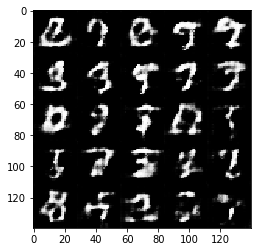

Epoch 1/2... Batch 210... Discriminator Loss: 1.3397... Generator Loss: 1.3236
Epoch 1/2... Batch 220... Discriminator Loss: 1.1941... Generator Loss: 0.8760
Epoch 1/2... Batch 230... Discriminator Loss: 1.3768... Generator Loss: 1.8446
Epoch 1/2... Batch 240... Discriminator Loss: 1.3533... Generator Loss: 1.6600
Epoch 1/2... Batch 250... Discriminator Loss: 1.0763... Generator Loss: 1.2424
Epoch 1/2... Batch 260... Discriminator Loss: 1.3416... Generator Loss: 0.6843
Epoch 1/2... Batch 270... Discriminator Loss: 1.0954... Generator Loss: 0.9453
Epoch 1/2... Batch 280... Discriminator Loss: 1.1616... Generator Loss: 0.8409
Epoch 1/2... Batch 290... Discriminator Loss: 1.2547... Generator Loss: 1.4535
Epoch 1/2... Batch 300... Discriminator Loss: 1.5241... Generator Loss: 0.4740


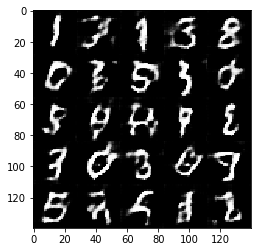

Epoch 1/2... Batch 310... Discriminator Loss: 1.2565... Generator Loss: 1.0277
Epoch 1/2... Batch 320... Discriminator Loss: 1.1504... Generator Loss: 1.0956
Epoch 1/2... Batch 330... Discriminator Loss: 2.2371... Generator Loss: 0.2175
Epoch 1/2... Batch 340... Discriminator Loss: 1.1874... Generator Loss: 0.7954
Epoch 1/2... Batch 350... Discriminator Loss: 1.1390... Generator Loss: 0.6851
Epoch 1/2... Batch 360... Discriminator Loss: 1.9395... Generator Loss: 2.7476
Epoch 1/2... Batch 370... Discriminator Loss: 1.2308... Generator Loss: 1.5511
Epoch 1/2... Batch 380... Discriminator Loss: 1.2055... Generator Loss: 0.6664
Epoch 1/2... Batch 390... Discriminator Loss: 1.1238... Generator Loss: 1.0313
Epoch 1/2... Batch 400... Discriminator Loss: 1.2056... Generator Loss: 0.8889


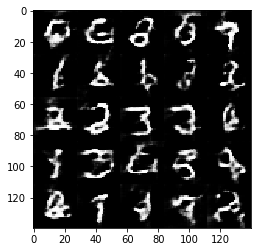

Epoch 1/2... Batch 410... Discriminator Loss: 1.0457... Generator Loss: 0.9295
Epoch 1/2... Batch 420... Discriminator Loss: 1.4329... Generator Loss: 0.5770
Epoch 1/2... Batch 430... Discriminator Loss: 1.0928... Generator Loss: 1.6756
Epoch 1/2... Batch 440... Discriminator Loss: 1.5174... Generator Loss: 0.4435
Epoch 1/2... Batch 450... Discriminator Loss: 1.1984... Generator Loss: 1.6827
Epoch 1/2... Batch 460... Discriminator Loss: 1.5672... Generator Loss: 0.4250
Epoch 1/2... Batch 470... Discriminator Loss: 1.1238... Generator Loss: 1.4609
Epoch 1/2... Batch 480... Discriminator Loss: 1.1784... Generator Loss: 0.9378
Epoch 1/2... Batch 490... Discriminator Loss: 1.2801... Generator Loss: 1.3966
Epoch 1/2... Batch 500... Discriminator Loss: 1.0996... Generator Loss: 1.1874


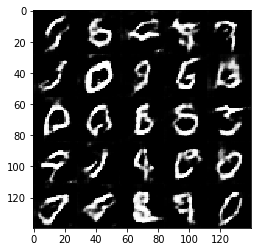

Epoch 1/2... Batch 510... Discriminator Loss: 1.0976... Generator Loss: 1.0019
Epoch 1/2... Batch 520... Discriminator Loss: 1.5655... Generator Loss: 2.8006
Epoch 1/2... Batch 530... Discriminator Loss: 1.0054... Generator Loss: 0.8954
Epoch 1/2... Batch 540... Discriminator Loss: 0.9961... Generator Loss: 1.6683
Epoch 1/2... Batch 550... Discriminator Loss: 1.2172... Generator Loss: 2.4020
Epoch 1/2... Batch 560... Discriminator Loss: 1.1699... Generator Loss: 1.7394
Epoch 1/2... Batch 570... Discriminator Loss: 1.6083... Generator Loss: 3.1611
Epoch 1/2... Batch 580... Discriminator Loss: 1.0650... Generator Loss: 0.9855
Epoch 1/2... Batch 590... Discriminator Loss: 1.0325... Generator Loss: 0.8653
Epoch 1/2... Batch 600... Discriminator Loss: 1.3589... Generator Loss: 0.6151


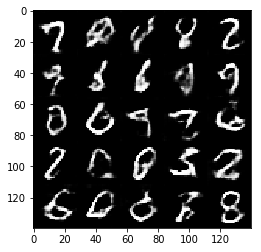

Epoch 1/2... Batch 610... Discriminator Loss: 1.0400... Generator Loss: 1.5086
Epoch 1/2... Batch 620... Discriminator Loss: 1.3141... Generator Loss: 0.6635
Epoch 1/2... Batch 630... Discriminator Loss: 1.2994... Generator Loss: 2.7569
Epoch 1/2... Batch 640... Discriminator Loss: 1.0346... Generator Loss: 1.3937
Epoch 1/2... Batch 650... Discriminator Loss: 1.0666... Generator Loss: 1.0766
Epoch 1/2... Batch 660... Discriminator Loss: 1.5395... Generator Loss: 2.7493
Epoch 1/2... Batch 670... Discriminator Loss: 0.9311... Generator Loss: 1.2368
Epoch 1/2... Batch 680... Discriminator Loss: 1.9943... Generator Loss: 0.3316
Epoch 1/2... Batch 690... Discriminator Loss: 1.0464... Generator Loss: 1.0745
Epoch 1/2... Batch 700... Discriminator Loss: 0.8818... Generator Loss: 1.7807


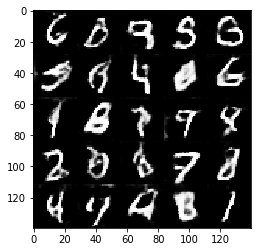

Epoch 1/2... Batch 710... Discriminator Loss: 0.9697... Generator Loss: 1.2665
Epoch 1/2... Batch 720... Discriminator Loss: 0.8471... Generator Loss: 1.6775
Epoch 1/2... Batch 730... Discriminator Loss: 1.2129... Generator Loss: 0.7784
Epoch 1/2... Batch 740... Discriminator Loss: 0.9228... Generator Loss: 1.9237
Epoch 1/2... Batch 750... Discriminator Loss: 2.1809... Generator Loss: 0.2603
Epoch 1/2... Batch 760... Discriminator Loss: 1.0472... Generator Loss: 0.8821
Epoch 1/2... Batch 770... Discriminator Loss: 0.7318... Generator Loss: 1.4685
Epoch 1/2... Batch 780... Discriminator Loss: 1.1641... Generator Loss: 0.8377
Epoch 1/2... Batch 790... Discriminator Loss: 0.9260... Generator Loss: 1.1011
Epoch 1/2... Batch 800... Discriminator Loss: 1.0025... Generator Loss: 2.2274


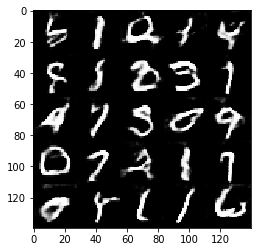

Epoch 1/2... Batch 810... Discriminator Loss: 0.7983... Generator Loss: 1.4978
Epoch 1/2... Batch 820... Discriminator Loss: 1.0915... Generator Loss: 3.3644
Epoch 1/2... Batch 830... Discriminator Loss: 1.1072... Generator Loss: 0.8829
Epoch 1/2... Batch 840... Discriminator Loss: 0.9650... Generator Loss: 1.1787
Epoch 1/2... Batch 850... Discriminator Loss: 1.0509... Generator Loss: 0.8606
Epoch 1/2... Batch 860... Discriminator Loss: 1.0550... Generator Loss: 1.0017
Epoch 1/2... Batch 870... Discriminator Loss: 0.8602... Generator Loss: 1.4451
Epoch 1/2... Batch 880... Discriminator Loss: 0.7795... Generator Loss: 2.2299
Epoch 1/2... Batch 890... Discriminator Loss: 1.6226... Generator Loss: 0.4760
Epoch 1/2... Batch 900... Discriminator Loss: 1.0831... Generator Loss: 1.0258


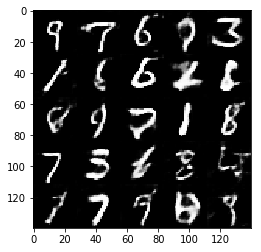

Epoch 1/2... Batch 910... Discriminator Loss: 1.0913... Generator Loss: 0.8637
Epoch 1/2... Batch 920... Discriminator Loss: 0.7113... Generator Loss: 2.0994
Epoch 1/2... Batch 930... Discriminator Loss: 1.2562... Generator Loss: 2.4036
Epoch 2/2... Batch 10... Discriminator Loss: 0.9056... Generator Loss: 2.6757
Epoch 2/2... Batch 20... Discriminator Loss: 0.8108... Generator Loss: 1.8823
Epoch 2/2... Batch 30... Discriminator Loss: 1.0047... Generator Loss: 1.0020
Epoch 2/2... Batch 40... Discriminator Loss: 0.7081... Generator Loss: 1.3335
Epoch 2/2... Batch 50... Discriminator Loss: 1.3038... Generator Loss: 0.7900
Epoch 2/2... Batch 60... Discriminator Loss: 1.0819... Generator Loss: 1.3046
Epoch 2/2... Batch 70... Discriminator Loss: 1.0222... Generator Loss: 1.1651
Epoch 2/2... Batch 80... Discriminator Loss: 0.8782... Generator Loss: 1.1130
Epoch 2/2... Batch 90... Discriminator Loss: 0.8873... Generator Loss: 2.7169
Epoch 2/2... Batch 100... Discriminator Loss: 1.1958... Gener

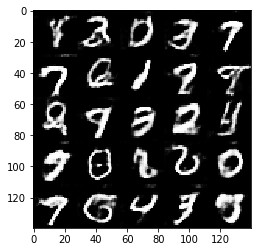

Epoch 2/2... Batch 110... Discriminator Loss: 1.0786... Generator Loss: 2.6724
Epoch 2/2... Batch 120... Discriminator Loss: 0.8096... Generator Loss: 1.3272
Epoch 2/2... Batch 130... Discriminator Loss: 0.7752... Generator Loss: 2.4930
Epoch 2/2... Batch 140... Discriminator Loss: 0.6704... Generator Loss: 1.5628
Epoch 2/2... Batch 150... Discriminator Loss: 1.5787... Generator Loss: 0.6432
Epoch 2/2... Batch 160... Discriminator Loss: 0.9070... Generator Loss: 1.3505
Epoch 2/2... Batch 170... Discriminator Loss: 0.8272... Generator Loss: 1.1887
Epoch 2/2... Batch 180... Discriminator Loss: 0.6969... Generator Loss: 1.6458
Epoch 2/2... Batch 190... Discriminator Loss: 0.6863... Generator Loss: 1.7139
Epoch 2/2... Batch 200... Discriminator Loss: 0.9939... Generator Loss: 1.0095


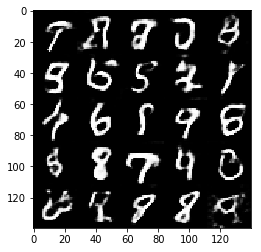

Epoch 2/2... Batch 210... Discriminator Loss: 0.5353... Generator Loss: 2.5607
Epoch 2/2... Batch 220... Discriminator Loss: 0.9406... Generator Loss: 2.5481
Epoch 2/2... Batch 230... Discriminator Loss: 0.7532... Generator Loss: 1.4860
Epoch 2/2... Batch 240... Discriminator Loss: 0.5592... Generator Loss: 2.6550
Epoch 2/2... Batch 250... Discriminator Loss: 0.6096... Generator Loss: 1.5168
Epoch 2/2... Batch 260... Discriminator Loss: 3.8549... Generator Loss: 6.7147
Epoch 2/2... Batch 270... Discriminator Loss: 0.8438... Generator Loss: 1.3675
Epoch 2/2... Batch 280... Discriminator Loss: 1.4159... Generator Loss: 0.7918
Epoch 2/2... Batch 290... Discriminator Loss: 0.8190... Generator Loss: 1.5764
Epoch 2/2... Batch 300... Discriminator Loss: 0.9131... Generator Loss: 1.2659


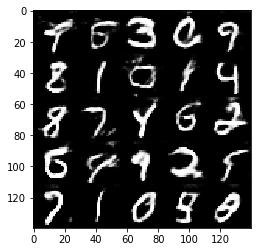

Epoch 2/2... Batch 310... Discriminator Loss: 0.8036... Generator Loss: 1.3356
Epoch 2/2... Batch 320... Discriminator Loss: 0.6689... Generator Loss: 2.0721
Epoch 2/2... Batch 330... Discriminator Loss: 0.5751... Generator Loss: 2.4456
Epoch 2/2... Batch 340... Discriminator Loss: 0.7797... Generator Loss: 1.5169
Epoch 2/2... Batch 350... Discriminator Loss: 0.4947... Generator Loss: 2.2960
Epoch 2/2... Batch 360... Discriminator Loss: 4.0565... Generator Loss: 6.0273
Epoch 2/2... Batch 370... Discriminator Loss: 0.9107... Generator Loss: 1.2753
Epoch 2/2... Batch 380... Discriminator Loss: 0.9621... Generator Loss: 1.2946
Epoch 2/2... Batch 390... Discriminator Loss: 0.7169... Generator Loss: 1.8177
Epoch 2/2... Batch 400... Discriminator Loss: 0.6613... Generator Loss: 2.3364


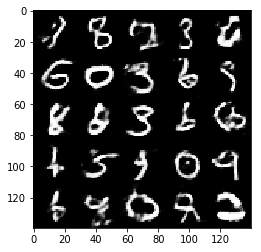

Epoch 2/2... Batch 410... Discriminator Loss: 0.7863... Generator Loss: 1.5130
Epoch 2/2... Batch 420... Discriminator Loss: 0.5294... Generator Loss: 2.6949
Epoch 2/2... Batch 430... Discriminator Loss: 0.9942... Generator Loss: 1.0253
Epoch 2/2... Batch 440... Discriminator Loss: 0.4740... Generator Loss: 2.4889
Epoch 2/2... Batch 450... Discriminator Loss: 0.4939... Generator Loss: 2.9173
Epoch 2/2... Batch 460... Discriminator Loss: 0.4773... Generator Loss: 2.3165
Epoch 2/2... Batch 470... Discriminator Loss: 1.2288... Generator Loss: 2.7119
Epoch 2/2... Batch 480... Discriminator Loss: 0.7732... Generator Loss: 1.6362
Epoch 2/2... Batch 490... Discriminator Loss: 0.6376... Generator Loss: 2.2302
Epoch 2/2... Batch 500... Discriminator Loss: 0.7147... Generator Loss: 1.8310


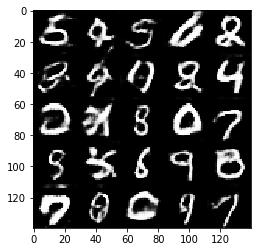

Epoch 2/2... Batch 510... Discriminator Loss: 0.5933... Generator Loss: 1.9327
Epoch 2/2... Batch 520... Discriminator Loss: 1.0301... Generator Loss: 3.9284
Epoch 2/2... Batch 530... Discriminator Loss: 0.5743... Generator Loss: 1.7534
Epoch 2/2... Batch 540... Discriminator Loss: 0.5921... Generator Loss: 1.7902
Epoch 2/2... Batch 550... Discriminator Loss: 0.6027... Generator Loss: 1.9592
Epoch 2/2... Batch 560... Discriminator Loss: 1.8662... Generator Loss: 4.9427
Epoch 2/2... Batch 570... Discriminator Loss: 0.6323... Generator Loss: 2.4708
Epoch 2/2... Batch 580... Discriminator Loss: 0.4923... Generator Loss: 2.7686
Epoch 2/2... Batch 590... Discriminator Loss: 0.6111... Generator Loss: 1.5550
Epoch 2/2... Batch 600... Discriminator Loss: 0.5373... Generator Loss: 2.3392


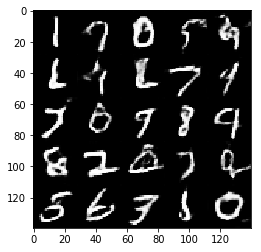

Epoch 2/2... Batch 610... Discriminator Loss: 0.4588... Generator Loss: 2.7749
Epoch 2/2... Batch 620... Discriminator Loss: 1.0307... Generator Loss: 1.0700
Epoch 2/2... Batch 630... Discriminator Loss: 0.8385... Generator Loss: 2.6619
Epoch 2/2... Batch 640... Discriminator Loss: 0.9136... Generator Loss: 1.1090
Epoch 2/2... Batch 650... Discriminator Loss: 0.7034... Generator Loss: 1.4065
Epoch 2/2... Batch 660... Discriminator Loss: 0.6041... Generator Loss: 3.0688
Epoch 2/2... Batch 670... Discriminator Loss: 0.4923... Generator Loss: 2.7471
Epoch 2/2... Batch 680... Discriminator Loss: 0.8170... Generator Loss: 1.4600
Epoch 2/2... Batch 690... Discriminator Loss: 0.8324... Generator Loss: 1.6954
Epoch 2/2... Batch 700... Discriminator Loss: 0.5701... Generator Loss: 2.6116


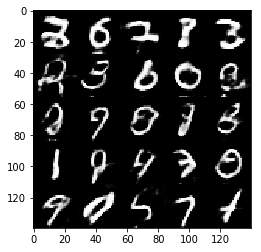

Epoch 2/2... Batch 710... Discriminator Loss: 0.5559... Generator Loss: 2.4491
Epoch 2/2... Batch 720... Discriminator Loss: 0.4605... Generator Loss: 3.4982
Epoch 2/2... Batch 730... Discriminator Loss: 0.5390... Generator Loss: 2.0232
Epoch 2/2... Batch 740... Discriminator Loss: 0.5637... Generator Loss: 1.9441
Epoch 2/2... Batch 750... Discriminator Loss: 0.4625... Generator Loss: 3.6140
Epoch 2/2... Batch 760... Discriminator Loss: 0.4858... Generator Loss: 2.0760
Epoch 2/2... Batch 770... Discriminator Loss: 0.4515... Generator Loss: 3.0388
Epoch 2/2... Batch 780... Discriminator Loss: 0.5616... Generator Loss: 1.9310
Epoch 2/2... Batch 790... Discriminator Loss: 1.6310... Generator Loss: 3.8122
Epoch 2/2... Batch 800... Discriminator Loss: 0.8622... Generator Loss: 1.3394


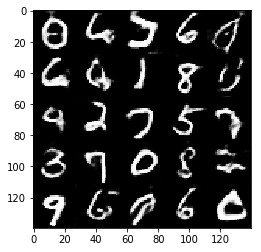

Epoch 2/2... Batch 810... Discriminator Loss: 0.7388... Generator Loss: 2.8616
Epoch 2/2... Batch 820... Discriminator Loss: 0.4785... Generator Loss: 2.0580
Epoch 2/2... Batch 830... Discriminator Loss: 0.6011... Generator Loss: 3.0638
Epoch 2/2... Batch 840... Discriminator Loss: 0.5303... Generator Loss: 2.0498
Epoch 2/2... Batch 850... Discriminator Loss: 0.5742... Generator Loss: 1.9110
Epoch 2/2... Batch 860... Discriminator Loss: 0.4242... Generator Loss: 2.8139
Epoch 2/2... Batch 870... Discriminator Loss: 0.8284... Generator Loss: 2.1234
Epoch 2/2... Batch 880... Discriminator Loss: 0.4140... Generator Loss: 3.8170
Epoch 2/2... Batch 890... Discriminator Loss: 0.5348... Generator Loss: 3.5227
Epoch 2/2... Batch 900... Discriminator Loss: 1.0908... Generator Loss: 3.9709


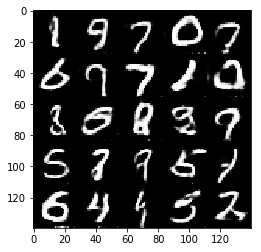

Epoch 2/2... Batch 910... Discriminator Loss: 1.1898... Generator Loss: 0.8658
Epoch 2/2... Batch 920... Discriminator Loss: 0.5056... Generator Loss: 3.3862
Epoch 2/2... Batch 930... Discriminator Loss: 0.6019... Generator Loss: 3.1293


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Batch 10... Discriminator Loss: 1.8422... Generator Loss: 1.2780
Epoch 1/2... Batch 20... Discriminator Loss: 0.7125... Generator Loss: 2.3984
Epoch 1/2... Batch 30... Discriminator Loss: 1.0779... Generator Loss: 1.0869
Epoch 1/2... Batch 40... Discriminator Loss: 1.2086... Generator Loss: 0.8528
Epoch 1/2... Batch 50... Discriminator Loss: 0.8894... Generator Loss: 1.4202
Epoch 1/2... Batch 60... Discriminator Loss: 1.0447... Generator Loss: 1.0865
Epoch 1/2... Batch 70... Discriminator Loss: 0.9429... Generator Loss: 1.7352
Epoch 1/2... Batch 80... Discriminator Loss: 1.4146... Generator Loss: 3.0863
Epoch 1/2... Batch 90... Discriminator Loss: 0.9469... Generator Loss: 1.4288
Epoch 1/2... Batch 100... Discriminator Loss: 2.0039... Generator Loss: 3.4642


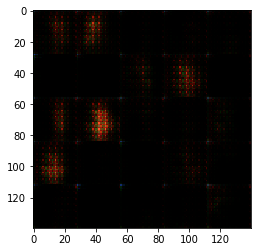

Epoch 1/2... Batch 110... Discriminator Loss: 0.9711... Generator Loss: 0.8966
Epoch 1/2... Batch 120... Discriminator Loss: 0.7704... Generator Loss: 1.5800
Epoch 1/2... Batch 130... Discriminator Loss: 1.8594... Generator Loss: 0.4609
Epoch 1/2... Batch 140... Discriminator Loss: 2.0348... Generator Loss: 2.4555
Epoch 1/2... Batch 150... Discriminator Loss: 1.0445... Generator Loss: 1.0479
Epoch 1/2... Batch 160... Discriminator Loss: 1.0455... Generator Loss: 1.1392
Epoch 1/2... Batch 170... Discriminator Loss: 1.0777... Generator Loss: 1.1129
Epoch 1/2... Batch 180... Discriminator Loss: 1.3151... Generator Loss: 0.5545
Epoch 1/2... Batch 190... Discriminator Loss: 1.4829... Generator Loss: 0.9091
Epoch 1/2... Batch 200... Discriminator Loss: 1.5132... Generator Loss: 1.2686


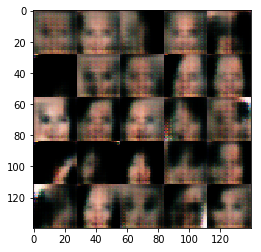

Epoch 1/2... Batch 210... Discriminator Loss: 1.2524... Generator Loss: 0.6536
Epoch 1/2... Batch 220... Discriminator Loss: 1.2907... Generator Loss: 0.7048
Epoch 1/2... Batch 230... Discriminator Loss: 1.3137... Generator Loss: 0.8196
Epoch 1/2... Batch 240... Discriminator Loss: 1.1843... Generator Loss: 0.7994
Epoch 1/2... Batch 250... Discriminator Loss: 1.4760... Generator Loss: 2.0443
Epoch 1/2... Batch 260... Discriminator Loss: 1.2284... Generator Loss: 0.7796
Epoch 1/2... Batch 270... Discriminator Loss: 1.2544... Generator Loss: 1.3207
Epoch 1/2... Batch 280... Discriminator Loss: 1.3008... Generator Loss: 0.9885
Epoch 1/2... Batch 290... Discriminator Loss: 1.4321... Generator Loss: 0.5904
Epoch 1/2... Batch 300... Discriminator Loss: 1.2097... Generator Loss: 0.8414


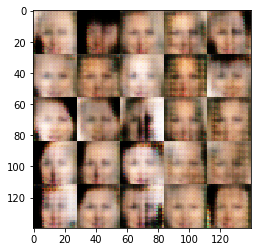

Epoch 1/2... Batch 310... Discriminator Loss: 1.6216... Generator Loss: 1.6210
Epoch 1/2... Batch 320... Discriminator Loss: 1.4386... Generator Loss: 1.2649
Epoch 1/2... Batch 330... Discriminator Loss: 1.2091... Generator Loss: 0.7983
Epoch 1/2... Batch 340... Discriminator Loss: 1.2809... Generator Loss: 0.7732
Epoch 1/2... Batch 350... Discriminator Loss: 1.0758... Generator Loss: 0.8743
Epoch 1/2... Batch 360... Discriminator Loss: 1.3179... Generator Loss: 0.5943
Epoch 1/2... Batch 370... Discriminator Loss: 1.3339... Generator Loss: 1.0154
Epoch 1/2... Batch 380... Discriminator Loss: 1.1738... Generator Loss: 0.6854
Epoch 1/2... Batch 390... Discriminator Loss: 1.6966... Generator Loss: 1.7548
Epoch 1/2... Batch 400... Discriminator Loss: 1.2973... Generator Loss: 0.8992


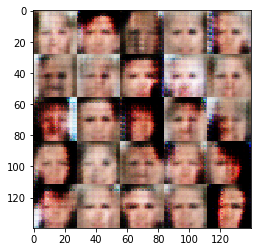

Epoch 1/2... Batch 410... Discriminator Loss: 1.3184... Generator Loss: 0.9408
Epoch 1/2... Batch 420... Discriminator Loss: 1.2752... Generator Loss: 1.6938
Epoch 1/2... Batch 430... Discriminator Loss: 1.2070... Generator Loss: 0.9837
Epoch 1/2... Batch 440... Discriminator Loss: 1.6612... Generator Loss: 0.4798
Epoch 1/2... Batch 450... Discriminator Loss: 1.0772... Generator Loss: 0.8440
Epoch 1/2... Batch 460... Discriminator Loss: 1.2239... Generator Loss: 1.5424
Epoch 1/2... Batch 470... Discriminator Loss: 1.3972... Generator Loss: 0.6276
Epoch 1/2... Batch 480... Discriminator Loss: 1.1649... Generator Loss: 1.0506
Epoch 1/2... Batch 490... Discriminator Loss: 1.2748... Generator Loss: 0.7425
Epoch 1/2... Batch 500... Discriminator Loss: 1.2887... Generator Loss: 0.8114


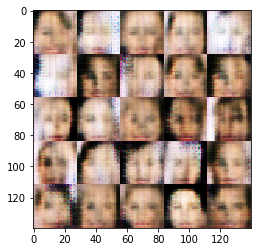

Epoch 1/2... Batch 510... Discriminator Loss: 1.5030... Generator Loss: 0.7204
Epoch 1/2... Batch 520... Discriminator Loss: 1.2040... Generator Loss: 0.8125
Epoch 1/2... Batch 530... Discriminator Loss: 1.5191... Generator Loss: 1.8992
Epoch 1/2... Batch 540... Discriminator Loss: 1.2014... Generator Loss: 0.8058
Epoch 1/2... Batch 550... Discriminator Loss: 1.6787... Generator Loss: 0.3931
Epoch 1/2... Batch 560... Discriminator Loss: 1.1784... Generator Loss: 0.7937
Epoch 1/2... Batch 570... Discriminator Loss: 1.3352... Generator Loss: 0.8790
Epoch 1/2... Batch 580... Discriminator Loss: 1.4619... Generator Loss: 0.4501
Epoch 1/2... Batch 590... Discriminator Loss: 1.0978... Generator Loss: 1.4655
Epoch 1/2... Batch 600... Discriminator Loss: 1.3130... Generator Loss: 1.4733


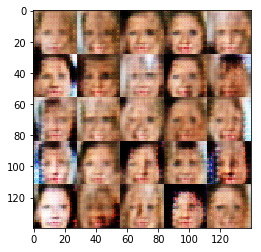

Epoch 1/2... Batch 610... Discriminator Loss: 1.8859... Generator Loss: 2.2136
Epoch 1/2... Batch 620... Discriminator Loss: 1.3992... Generator Loss: 0.8154
Epoch 1/2... Batch 630... Discriminator Loss: 1.1611... Generator Loss: 1.1258
Epoch 1/2... Batch 640... Discriminator Loss: 1.2594... Generator Loss: 0.6700
Epoch 1/2... Batch 650... Discriminator Loss: 1.1788... Generator Loss: 0.6796
Epoch 1/2... Batch 660... Discriminator Loss: 1.2221... Generator Loss: 0.7953
Epoch 1/2... Batch 670... Discriminator Loss: 1.2813... Generator Loss: 1.9377
Epoch 1/2... Batch 680... Discriminator Loss: 1.0420... Generator Loss: 1.0286
Epoch 1/2... Batch 690... Discriminator Loss: 3.0610... Generator Loss: 3.0952
Epoch 1/2... Batch 700... Discriminator Loss: 1.0338... Generator Loss: 0.9108


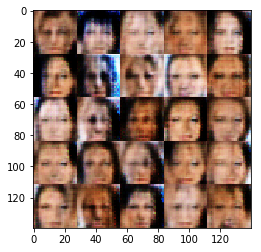

Epoch 1/2... Batch 710... Discriminator Loss: 1.5920... Generator Loss: 0.8589
Epoch 1/2... Batch 720... Discriminator Loss: 1.1383... Generator Loss: 0.9191
Epoch 1/2... Batch 730... Discriminator Loss: 1.3116... Generator Loss: 0.5866
Epoch 1/2... Batch 740... Discriminator Loss: 1.2252... Generator Loss: 1.1454
Epoch 1/2... Batch 750... Discriminator Loss: 1.2194... Generator Loss: 1.2753
Epoch 1/2... Batch 760... Discriminator Loss: 1.2516... Generator Loss: 1.5283
Epoch 1/2... Batch 770... Discriminator Loss: 1.2179... Generator Loss: 1.7173
Epoch 1/2... Batch 780... Discriminator Loss: 1.1962... Generator Loss: 1.1335
Epoch 1/2... Batch 790... Discriminator Loss: 1.1464... Generator Loss: 0.9699
Epoch 1/2... Batch 800... Discriminator Loss: 1.0940... Generator Loss: 1.2544


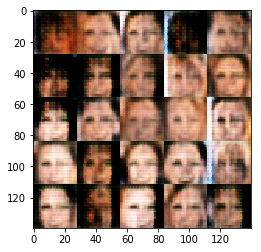

Epoch 1/2... Batch 810... Discriminator Loss: 1.1253... Generator Loss: 0.7843
Epoch 1/2... Batch 820... Discriminator Loss: 1.3032... Generator Loss: 1.7050
Epoch 1/2... Batch 830... Discriminator Loss: 1.4256... Generator Loss: 1.7994
Epoch 1/2... Batch 840... Discriminator Loss: 1.3344... Generator Loss: 0.9390
Epoch 1/2... Batch 850... Discriminator Loss: 1.2045... Generator Loss: 1.7827
Epoch 1/2... Batch 860... Discriminator Loss: 1.0725... Generator Loss: 0.9858
Epoch 1/2... Batch 870... Discriminator Loss: 1.0953... Generator Loss: 1.0442
Epoch 1/2... Batch 880... Discriminator Loss: 1.0140... Generator Loss: 1.2755
Epoch 1/2... Batch 890... Discriminator Loss: 1.6434... Generator Loss: 1.7266
Epoch 1/2... Batch 900... Discriminator Loss: 1.3706... Generator Loss: 0.7083


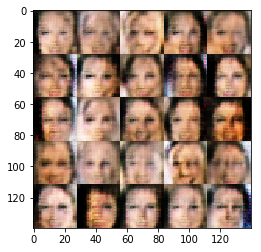

Epoch 1/2... Batch 910... Discriminator Loss: 1.1768... Generator Loss: 0.8771
Epoch 1/2... Batch 920... Discriminator Loss: 1.0928... Generator Loss: 0.9984
Epoch 1/2... Batch 930... Discriminator Loss: 1.1709... Generator Loss: 1.3991
Epoch 1/2... Batch 940... Discriminator Loss: 1.1093... Generator Loss: 2.0889
Epoch 1/2... Batch 950... Discriminator Loss: 1.0602... Generator Loss: 1.1319
Epoch 1/2... Batch 960... Discriminator Loss: 1.2317... Generator Loss: 2.0928
Epoch 1/2... Batch 970... Discriminator Loss: 1.2100... Generator Loss: 1.2182
Epoch 1/2... Batch 980... Discriminator Loss: 1.2791... Generator Loss: 1.3274
Epoch 1/2... Batch 990... Discriminator Loss: 1.0996... Generator Loss: 1.1955
Epoch 1/2... Batch 1000... Discriminator Loss: 1.0537... Generator Loss: 1.4568


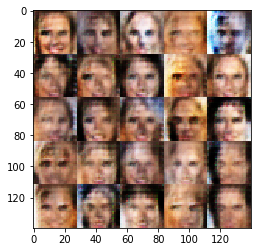

Epoch 1/2... Batch 1010... Discriminator Loss: 1.8092... Generator Loss: 0.3633
Epoch 1/2... Batch 1020... Discriminator Loss: 1.2348... Generator Loss: 0.7781
Epoch 1/2... Batch 1030... Discriminator Loss: 1.0841... Generator Loss: 1.0633
Epoch 1/2... Batch 1040... Discriminator Loss: 1.1844... Generator Loss: 1.9302
Epoch 1/2... Batch 1050... Discriminator Loss: 1.0379... Generator Loss: 1.2271
Epoch 1/2... Batch 1060... Discriminator Loss: 1.3346... Generator Loss: 0.5943
Epoch 1/2... Batch 1070... Discriminator Loss: 1.0383... Generator Loss: 0.9127
Epoch 1/2... Batch 1080... Discriminator Loss: 1.1278... Generator Loss: 1.0306
Epoch 1/2... Batch 1090... Discriminator Loss: 1.0527... Generator Loss: 0.8840
Epoch 1/2... Batch 1100... Discriminator Loss: 1.2486... Generator Loss: 0.7179


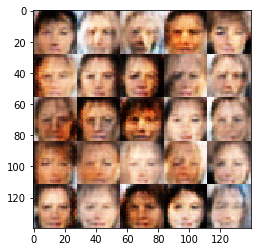

Epoch 1/2... Batch 1110... Discriminator Loss: 1.2420... Generator Loss: 1.0545
Epoch 1/2... Batch 1120... Discriminator Loss: 1.4623... Generator Loss: 1.7549
Epoch 1/2... Batch 1130... Discriminator Loss: 0.9339... Generator Loss: 1.3576
Epoch 1/2... Batch 1140... Discriminator Loss: 1.0698... Generator Loss: 0.9673
Epoch 1/2... Batch 1150... Discriminator Loss: 1.0533... Generator Loss: 1.3680
Epoch 1/2... Batch 1160... Discriminator Loss: 1.2879... Generator Loss: 0.7201
Epoch 1/2... Batch 1170... Discriminator Loss: 1.5511... Generator Loss: 0.5099
Epoch 1/2... Batch 1180... Discriminator Loss: 1.3453... Generator Loss: 0.9294
Epoch 1/2... Batch 1190... Discriminator Loss: 1.0283... Generator Loss: 1.4011
Epoch 1/2... Batch 1200... Discriminator Loss: 1.1747... Generator Loss: 1.3005


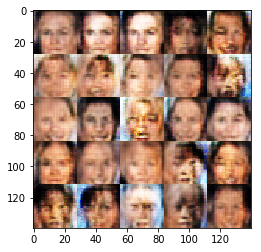

Epoch 1/2... Batch 1210... Discriminator Loss: 0.7887... Generator Loss: 1.7667
Epoch 1/2... Batch 1220... Discriminator Loss: 1.2941... Generator Loss: 0.7132
Epoch 1/2... Batch 1230... Discriminator Loss: 1.2619... Generator Loss: 0.8433
Epoch 1/2... Batch 1240... Discriminator Loss: 1.0715... Generator Loss: 0.8711
Epoch 1/2... Batch 1250... Discriminator Loss: 1.6763... Generator Loss: 1.6348
Epoch 1/2... Batch 1260... Discriminator Loss: 1.4488... Generator Loss: 0.4714
Epoch 1/2... Batch 1270... Discriminator Loss: 1.1638... Generator Loss: 1.0532
Epoch 1/2... Batch 1280... Discriminator Loss: 0.9791... Generator Loss: 0.8525
Epoch 1/2... Batch 1290... Discriminator Loss: 0.9426... Generator Loss: 1.0299
Epoch 1/2... Batch 1300... Discriminator Loss: 0.9568... Generator Loss: 0.9624


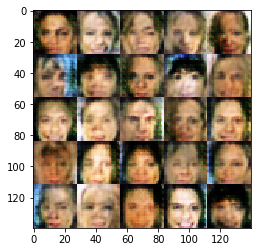

Epoch 1/2... Batch 1310... Discriminator Loss: 1.2857... Generator Loss: 0.6926
Epoch 1/2... Batch 1320... Discriminator Loss: 1.0331... Generator Loss: 1.3040
Epoch 1/2... Batch 1330... Discriminator Loss: 1.5264... Generator Loss: 0.5229
Epoch 1/2... Batch 1340... Discriminator Loss: 1.3078... Generator Loss: 1.0507
Epoch 1/2... Batch 1350... Discriminator Loss: 1.1588... Generator Loss: 1.0831
Epoch 1/2... Batch 1360... Discriminator Loss: 1.0576... Generator Loss: 1.3157
Epoch 1/2... Batch 1370... Discriminator Loss: 1.1503... Generator Loss: 1.2102
Epoch 1/2... Batch 1380... Discriminator Loss: 1.0484... Generator Loss: 1.2741
Epoch 1/2... Batch 1390... Discriminator Loss: 1.0774... Generator Loss: 1.0956
Epoch 1/2... Batch 1400... Discriminator Loss: 1.1766... Generator Loss: 1.0030


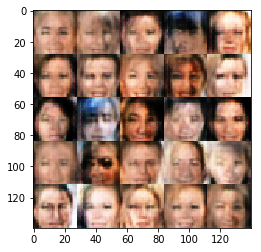

Epoch 1/2... Batch 1410... Discriminator Loss: 1.2818... Generator Loss: 1.0202
Epoch 1/2... Batch 1420... Discriminator Loss: 1.1163... Generator Loss: 1.3206
Epoch 1/2... Batch 1430... Discriminator Loss: 1.3722... Generator Loss: 0.9860
Epoch 1/2... Batch 1440... Discriminator Loss: 1.2398... Generator Loss: 1.4522
Epoch 1/2... Batch 1450... Discriminator Loss: 1.2035... Generator Loss: 1.1372
Epoch 1/2... Batch 1460... Discriminator Loss: 1.6080... Generator Loss: 1.9764
Epoch 1/2... Batch 1470... Discriminator Loss: 1.0629... Generator Loss: 1.4649
Epoch 1/2... Batch 1480... Discriminator Loss: 1.1807... Generator Loss: 1.1617
Epoch 1/2... Batch 1490... Discriminator Loss: 1.0945... Generator Loss: 1.2120
Epoch 1/2... Batch 1500... Discriminator Loss: 0.8650... Generator Loss: 1.1941


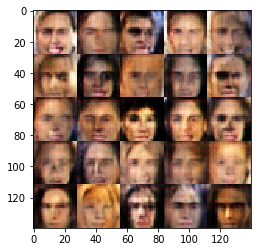

Epoch 1/2... Batch 1510... Discriminator Loss: 1.3396... Generator Loss: 1.4870
Epoch 1/2... Batch 1520... Discriminator Loss: 1.3397... Generator Loss: 0.6117
Epoch 1/2... Batch 1530... Discriminator Loss: 1.2789... Generator Loss: 1.0373
Epoch 1/2... Batch 1540... Discriminator Loss: 1.1343... Generator Loss: 0.8506
Epoch 1/2... Batch 1550... Discriminator Loss: 1.5155... Generator Loss: 0.5225
Epoch 1/2... Batch 1560... Discriminator Loss: 1.0051... Generator Loss: 1.6789
Epoch 1/2... Batch 1570... Discriminator Loss: 1.3489... Generator Loss: 0.9716
Epoch 1/2... Batch 1580... Discriminator Loss: 0.9747... Generator Loss: 0.9950
Epoch 1/2... Batch 1590... Discriminator Loss: 1.2882... Generator Loss: 0.8956
Epoch 1/2... Batch 1600... Discriminator Loss: 1.1208... Generator Loss: 0.9105


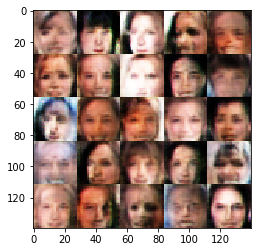

Epoch 1/2... Batch 1610... Discriminator Loss: 1.0294... Generator Loss: 1.0690
Epoch 1/2... Batch 1620... Discriminator Loss: 1.0000... Generator Loss: 1.0602
Epoch 1/2... Batch 1630... Discriminator Loss: 1.5905... Generator Loss: 2.8290
Epoch 1/2... Batch 1640... Discriminator Loss: 1.3295... Generator Loss: 0.6359
Epoch 1/2... Batch 1650... Discriminator Loss: 1.6354... Generator Loss: 0.4096
Epoch 1/2... Batch 1660... Discriminator Loss: 1.1048... Generator Loss: 1.3021
Epoch 1/2... Batch 1670... Discriminator Loss: 1.6108... Generator Loss: 1.9982
Epoch 1/2... Batch 1680... Discriminator Loss: 1.1867... Generator Loss: 0.8413
Epoch 1/2... Batch 1690... Discriminator Loss: 1.0517... Generator Loss: 0.9550
Epoch 1/2... Batch 1700... Discriminator Loss: 1.0632... Generator Loss: 1.2764


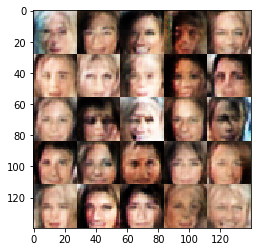

Epoch 1/2... Batch 1710... Discriminator Loss: 0.9349... Generator Loss: 1.0500
Epoch 1/2... Batch 1720... Discriminator Loss: 1.2160... Generator Loss: 0.7023
Epoch 1/2... Batch 1730... Discriminator Loss: 0.9747... Generator Loss: 1.0524
Epoch 1/2... Batch 1740... Discriminator Loss: 1.5002... Generator Loss: 0.5329
Epoch 1/2... Batch 1750... Discriminator Loss: 1.2077... Generator Loss: 0.8384
Epoch 1/2... Batch 1760... Discriminator Loss: 1.3706... Generator Loss: 1.7420
Epoch 1/2... Batch 1770... Discriminator Loss: 1.0696... Generator Loss: 1.2099
Epoch 1/2... Batch 1780... Discriminator Loss: 1.1629... Generator Loss: 0.8665
Epoch 1/2... Batch 1790... Discriminator Loss: 1.1912... Generator Loss: 1.0771
Epoch 1/2... Batch 1800... Discriminator Loss: 1.0893... Generator Loss: 1.5360


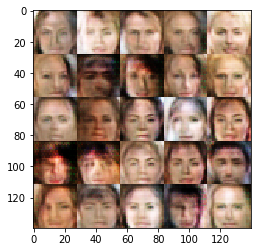

Epoch 1/2... Batch 1810... Discriminator Loss: 1.2419... Generator Loss: 0.7229
Epoch 1/2... Batch 1820... Discriminator Loss: 1.5647... Generator Loss: 0.4757
Epoch 1/2... Batch 1830... Discriminator Loss: 1.1616... Generator Loss: 0.8116
Epoch 1/2... Batch 1840... Discriminator Loss: 1.1284... Generator Loss: 0.9217
Epoch 1/2... Batch 1850... Discriminator Loss: 0.9569... Generator Loss: 0.9925
Epoch 1/2... Batch 1860... Discriminator Loss: 1.4414... Generator Loss: 0.5187
Epoch 1/2... Batch 1870... Discriminator Loss: 1.5492... Generator Loss: 2.0020
Epoch 1/2... Batch 1880... Discriminator Loss: 1.0648... Generator Loss: 1.3950
Epoch 1/2... Batch 1890... Discriminator Loss: 1.0721... Generator Loss: 1.0986
Epoch 1/2... Batch 1900... Discriminator Loss: 1.2281... Generator Loss: 1.1106


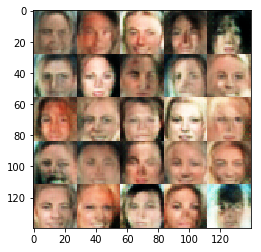

Epoch 1/2... Batch 1910... Discriminator Loss: 1.0688... Generator Loss: 0.9603
Epoch 1/2... Batch 1920... Discriminator Loss: 1.0544... Generator Loss: 1.2763
Epoch 1/2... Batch 1930... Discriminator Loss: 1.2605... Generator Loss: 0.6836
Epoch 1/2... Batch 1940... Discriminator Loss: 1.1389... Generator Loss: 1.2104
Epoch 1/2... Batch 1950... Discriminator Loss: 1.0540... Generator Loss: 1.2140
Epoch 1/2... Batch 1960... Discriminator Loss: 1.3721... Generator Loss: 0.5055
Epoch 1/2... Batch 1970... Discriminator Loss: 1.2368... Generator Loss: 1.5610
Epoch 1/2... Batch 1980... Discriminator Loss: 1.1364... Generator Loss: 1.6506
Epoch 1/2... Batch 1990... Discriminator Loss: 0.9976... Generator Loss: 1.3051
Epoch 1/2... Batch 2000... Discriminator Loss: 1.0246... Generator Loss: 0.9262


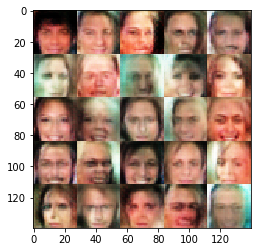

Epoch 1/2... Batch 2010... Discriminator Loss: 1.2484... Generator Loss: 1.1008
Epoch 1/2... Batch 2020... Discriminator Loss: 1.1600... Generator Loss: 1.2559
Epoch 1/2... Batch 2030... Discriminator Loss: 1.0831... Generator Loss: 1.0133
Epoch 1/2... Batch 2040... Discriminator Loss: 0.9779... Generator Loss: 1.1598
Epoch 1/2... Batch 2050... Discriminator Loss: 1.2279... Generator Loss: 1.4555
Epoch 1/2... Batch 2060... Discriminator Loss: 1.1224... Generator Loss: 1.2880
Epoch 1/2... Batch 2070... Discriminator Loss: 1.1266... Generator Loss: 1.1252
Epoch 1/2... Batch 2080... Discriminator Loss: 1.3088... Generator Loss: 2.2163
Epoch 1/2... Batch 2090... Discriminator Loss: 1.1734... Generator Loss: 1.0768
Epoch 1/2... Batch 2100... Discriminator Loss: 0.8789... Generator Loss: 1.1674


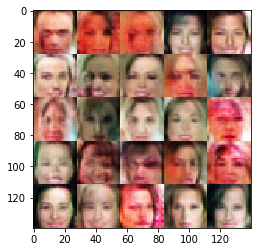

Epoch 1/2... Batch 2110... Discriminator Loss: 1.2585... Generator Loss: 0.7274
Epoch 1/2... Batch 2120... Discriminator Loss: 1.7521... Generator Loss: 0.4127
Epoch 1/2... Batch 2130... Discriminator Loss: 1.3625... Generator Loss: 2.4995
Epoch 1/2... Batch 2140... Discriminator Loss: 0.9620... Generator Loss: 1.1774
Epoch 1/2... Batch 2150... Discriminator Loss: 0.9544... Generator Loss: 1.2104
Epoch 1/2... Batch 2160... Discriminator Loss: 1.0925... Generator Loss: 1.3473
Epoch 1/2... Batch 2170... Discriminator Loss: 1.2032... Generator Loss: 1.1198
Epoch 1/2... Batch 2180... Discriminator Loss: 1.0802... Generator Loss: 0.9010
Epoch 1/2... Batch 2190... Discriminator Loss: 0.8523... Generator Loss: 1.1547
Epoch 1/2... Batch 2200... Discriminator Loss: 1.5118... Generator Loss: 2.5766


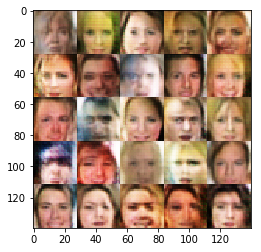

Epoch 1/2... Batch 2210... Discriminator Loss: 1.1433... Generator Loss: 0.8306
Epoch 1/2... Batch 2220... Discriminator Loss: 1.3472... Generator Loss: 0.8327
Epoch 1/2... Batch 2230... Discriminator Loss: 1.1476... Generator Loss: 0.8138
Epoch 1/2... Batch 2240... Discriminator Loss: 0.9907... Generator Loss: 1.1852
Epoch 1/2... Batch 2250... Discriminator Loss: 1.5743... Generator Loss: 2.3237
Epoch 1/2... Batch 2260... Discriminator Loss: 1.0741... Generator Loss: 1.2207
Epoch 1/2... Batch 2270... Discriminator Loss: 1.1099... Generator Loss: 1.4846
Epoch 1/2... Batch 2280... Discriminator Loss: 1.2264... Generator Loss: 0.9048
Epoch 1/2... Batch 2290... Discriminator Loss: 1.2542... Generator Loss: 0.9477
Epoch 1/2... Batch 2300... Discriminator Loss: 1.1349... Generator Loss: 0.8251


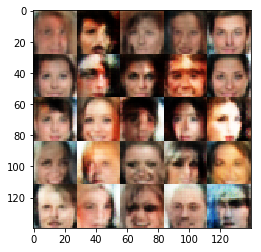

Epoch 1/2... Batch 2310... Discriminator Loss: 1.6961... Generator Loss: 2.7416
Epoch 1/2... Batch 2320... Discriminator Loss: 0.9441... Generator Loss: 1.6190
Epoch 1/2... Batch 2330... Discriminator Loss: 0.9980... Generator Loss: 1.2807
Epoch 1/2... Batch 2340... Discriminator Loss: 1.1512... Generator Loss: 1.2831
Epoch 1/2... Batch 2350... Discriminator Loss: 1.1106... Generator Loss: 0.6994
Epoch 1/2... Batch 2360... Discriminator Loss: 1.0950... Generator Loss: 1.8083
Epoch 1/2... Batch 2370... Discriminator Loss: 1.0660... Generator Loss: 1.8385
Epoch 1/2... Batch 2380... Discriminator Loss: 1.1676... Generator Loss: 0.7480
Epoch 1/2... Batch 2390... Discriminator Loss: 1.3117... Generator Loss: 0.7745
Epoch 1/2... Batch 2400... Discriminator Loss: 1.1908... Generator Loss: 0.7023


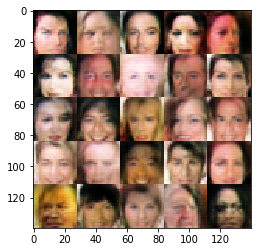

Epoch 1/2... Batch 2410... Discriminator Loss: 0.9971... Generator Loss: 1.0517
Epoch 1/2... Batch 2420... Discriminator Loss: 0.9770... Generator Loss: 1.2284
Epoch 1/2... Batch 2430... Discriminator Loss: 0.9720... Generator Loss: 0.9706
Epoch 1/2... Batch 2440... Discriminator Loss: 1.1240... Generator Loss: 1.0499
Epoch 1/2... Batch 2450... Discriminator Loss: 0.8619... Generator Loss: 1.0629
Epoch 1/2... Batch 2460... Discriminator Loss: 1.6183... Generator Loss: 2.5532
Epoch 1/2... Batch 2470... Discriminator Loss: 1.4682... Generator Loss: 2.1096
Epoch 1/2... Batch 2480... Discriminator Loss: 1.1758... Generator Loss: 0.7966
Epoch 1/2... Batch 2490... Discriminator Loss: 1.9418... Generator Loss: 0.3410
Epoch 1/2... Batch 2500... Discriminator Loss: 1.1286... Generator Loss: 1.3192


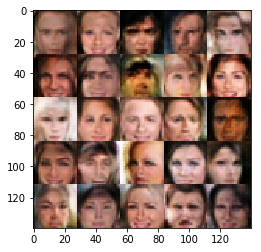

Epoch 1/2... Batch 2510... Discriminator Loss: 1.0370... Generator Loss: 0.8345
Epoch 1/2... Batch 2520... Discriminator Loss: 1.2268... Generator Loss: 1.6346
Epoch 1/2... Batch 2530... Discriminator Loss: 0.8805... Generator Loss: 1.1769
Epoch 1/2... Batch 2540... Discriminator Loss: 1.0199... Generator Loss: 1.3802
Epoch 1/2... Batch 2550... Discriminator Loss: 0.9505... Generator Loss: 1.2891
Epoch 1/2... Batch 2560... Discriminator Loss: 1.1017... Generator Loss: 1.5452
Epoch 1/2... Batch 2570... Discriminator Loss: 0.9910... Generator Loss: 1.3740
Epoch 1/2... Batch 2580... Discriminator Loss: 0.9992... Generator Loss: 1.1574
Epoch 1/2... Batch 2590... Discriminator Loss: 1.1263... Generator Loss: 0.8423
Epoch 1/2... Batch 2600... Discriminator Loss: 0.8547... Generator Loss: 1.4452


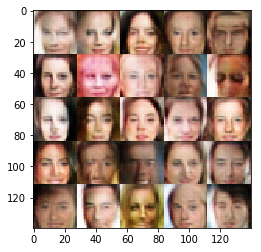

Epoch 1/2... Batch 2610... Discriminator Loss: 0.9427... Generator Loss: 1.4307
Epoch 1/2... Batch 2620... Discriminator Loss: 1.1875... Generator Loss: 0.7288
Epoch 1/2... Batch 2630... Discriminator Loss: 1.0732... Generator Loss: 1.5978
Epoch 1/2... Batch 2640... Discriminator Loss: 1.1675... Generator Loss: 1.3210
Epoch 1/2... Batch 2650... Discriminator Loss: 1.0611... Generator Loss: 0.9921
Epoch 1/2... Batch 2660... Discriminator Loss: 1.2933... Generator Loss: 0.6981
Epoch 1/2... Batch 2670... Discriminator Loss: 1.0457... Generator Loss: 1.0342
Epoch 1/2... Batch 2680... Discriminator Loss: 1.1631... Generator Loss: 0.8657
Epoch 1/2... Batch 2690... Discriminator Loss: 1.0041... Generator Loss: 1.2862
Epoch 1/2... Batch 2700... Discriminator Loss: 1.1133... Generator Loss: 0.6802


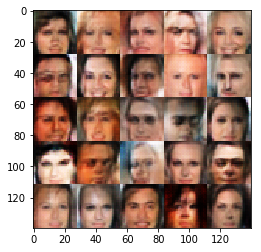

Epoch 1/2... Batch 2710... Discriminator Loss: 0.9386... Generator Loss: 1.3944
Epoch 1/2... Batch 2720... Discriminator Loss: 1.2705... Generator Loss: 0.7507
Epoch 1/2... Batch 2730... Discriminator Loss: 1.1149... Generator Loss: 0.9251
Epoch 1/2... Batch 2740... Discriminator Loss: 1.0369... Generator Loss: 1.1636
Epoch 1/2... Batch 2750... Discriminator Loss: 1.0171... Generator Loss: 0.9189
Epoch 1/2... Batch 2760... Discriminator Loss: 1.2137... Generator Loss: 0.7604
Epoch 1/2... Batch 2770... Discriminator Loss: 0.9172... Generator Loss: 1.4696
Epoch 1/2... Batch 2780... Discriminator Loss: 1.2031... Generator Loss: 0.7744
Epoch 1/2... Batch 2790... Discriminator Loss: 1.1048... Generator Loss: 0.8648
Epoch 1/2... Batch 2800... Discriminator Loss: 1.1624... Generator Loss: 0.7080


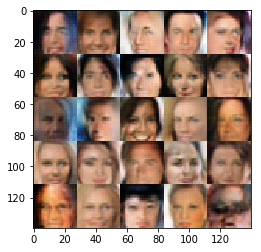

Epoch 1/2... Batch 2810... Discriminator Loss: 1.7197... Generator Loss: 0.4071
Epoch 1/2... Batch 2820... Discriminator Loss: 0.9650... Generator Loss: 1.0028
Epoch 1/2... Batch 2830... Discriminator Loss: 0.9976... Generator Loss: 1.8714
Epoch 1/2... Batch 2840... Discriminator Loss: 0.7897... Generator Loss: 1.8140
Epoch 1/2... Batch 2850... Discriminator Loss: 0.9570... Generator Loss: 1.6157
Epoch 1/2... Batch 2860... Discriminator Loss: 0.9746... Generator Loss: 1.3838
Epoch 1/2... Batch 2870... Discriminator Loss: 0.9868... Generator Loss: 1.5995
Epoch 1/2... Batch 2880... Discriminator Loss: 0.8436... Generator Loss: 1.6374
Epoch 1/2... Batch 2890... Discriminator Loss: 1.1669... Generator Loss: 1.3699
Epoch 1/2... Batch 2900... Discriminator Loss: 1.1584... Generator Loss: 1.0314


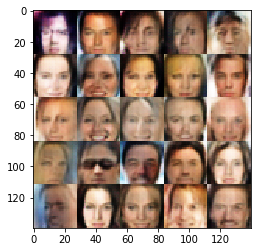

Epoch 1/2... Batch 2910... Discriminator Loss: 0.9658... Generator Loss: 1.2354
Epoch 1/2... Batch 2920... Discriminator Loss: 1.1618... Generator Loss: 2.0332
Epoch 1/2... Batch 2930... Discriminator Loss: 1.2089... Generator Loss: 0.7531
Epoch 1/2... Batch 2940... Discriminator Loss: 1.3416... Generator Loss: 0.6019
Epoch 1/2... Batch 2950... Discriminator Loss: 1.0017... Generator Loss: 1.4901
Epoch 1/2... Batch 2960... Discriminator Loss: 1.0438... Generator Loss: 1.8502
Epoch 1/2... Batch 2970... Discriminator Loss: 1.0020... Generator Loss: 1.5461
Epoch 1/2... Batch 2980... Discriminator Loss: 1.6308... Generator Loss: 0.4326
Epoch 1/2... Batch 2990... Discriminator Loss: 1.0624... Generator Loss: 0.9249
Epoch 1/2... Batch 3000... Discriminator Loss: 0.8814... Generator Loss: 1.1232


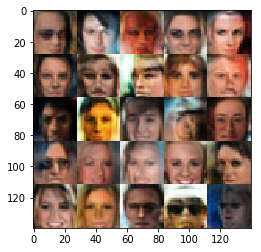

Epoch 1/2... Batch 3010... Discriminator Loss: 0.9535... Generator Loss: 1.3409
Epoch 1/2... Batch 3020... Discriminator Loss: 0.9649... Generator Loss: 1.5838
Epoch 1/2... Batch 3030... Discriminator Loss: 0.9853... Generator Loss: 1.1130
Epoch 1/2... Batch 3040... Discriminator Loss: 0.9144... Generator Loss: 1.2482
Epoch 1/2... Batch 3050... Discriminator Loss: 0.9042... Generator Loss: 1.5098
Epoch 1/2... Batch 3060... Discriminator Loss: 1.0273... Generator Loss: 1.0706
Epoch 1/2... Batch 3070... Discriminator Loss: 0.9622... Generator Loss: 1.1386
Epoch 1/2... Batch 3080... Discriminator Loss: 0.8962... Generator Loss: 1.1005
Epoch 1/2... Batch 3090... Discriminator Loss: 0.9615... Generator Loss: 1.0518
Epoch 1/2... Batch 3100... Discriminator Loss: 0.8736... Generator Loss: 1.4815


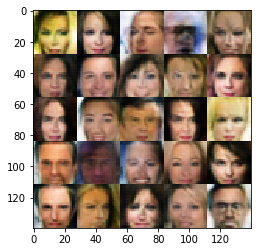

Epoch 1/2... Batch 3110... Discriminator Loss: 0.9364... Generator Loss: 1.9452
Epoch 1/2... Batch 3120... Discriminator Loss: 1.0612... Generator Loss: 1.0478
Epoch 1/2... Batch 3130... Discriminator Loss: 1.1846... Generator Loss: 0.8812
Epoch 1/2... Batch 3140... Discriminator Loss: 0.9070... Generator Loss: 1.0196
Epoch 1/2... Batch 3150... Discriminator Loss: 1.1120... Generator Loss: 2.1921
Epoch 1/2... Batch 3160... Discriminator Loss: 0.8740... Generator Loss: 1.6693
Epoch 2/2... Batch 10... Discriminator Loss: 1.3264... Generator Loss: 0.7056
Epoch 2/2... Batch 20... Discriminator Loss: 1.0743... Generator Loss: 0.8790
Epoch 2/2... Batch 30... Discriminator Loss: 1.0685... Generator Loss: 1.6906
Epoch 2/2... Batch 40... Discriminator Loss: 0.8406... Generator Loss: 1.3052
Epoch 2/2... Batch 50... Discriminator Loss: 2.3602... Generator Loss: 3.1826
Epoch 2/2... Batch 60... Discriminator Loss: 0.9973... Generator Loss: 1.5702
Epoch 2/2... Batch 70... Discriminator Loss: 1.3191.

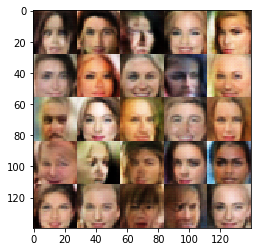

Epoch 2/2... Batch 110... Discriminator Loss: 0.9083... Generator Loss: 1.1009
Epoch 2/2... Batch 120... Discriminator Loss: 1.1126... Generator Loss: 1.6810
Epoch 2/2... Batch 130... Discriminator Loss: 1.2509... Generator Loss: 0.7445
Epoch 2/2... Batch 140... Discriminator Loss: 1.0379... Generator Loss: 1.5945
Epoch 2/2... Batch 150... Discriminator Loss: 1.1283... Generator Loss: 0.7683
Epoch 2/2... Batch 160... Discriminator Loss: 1.1121... Generator Loss: 0.9122
Epoch 2/2... Batch 170... Discriminator Loss: 1.2866... Generator Loss: 0.7182
Epoch 2/2... Batch 180... Discriminator Loss: 0.8696... Generator Loss: 1.6776
Epoch 2/2... Batch 190... Discriminator Loss: 0.8718... Generator Loss: 1.1129
Epoch 2/2... Batch 200... Discriminator Loss: 1.0518... Generator Loss: 0.9180


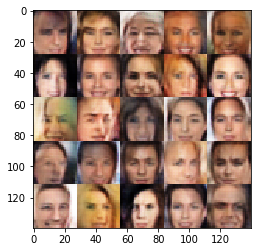

Epoch 2/2... Batch 210... Discriminator Loss: 0.8435... Generator Loss: 1.8108
Epoch 2/2... Batch 220... Discriminator Loss: 0.9200... Generator Loss: 1.2721
Epoch 2/2... Batch 230... Discriminator Loss: 1.3332... Generator Loss: 3.2633
Epoch 2/2... Batch 240... Discriminator Loss: 0.7236... Generator Loss: 1.5990
Epoch 2/2... Batch 250... Discriminator Loss: 1.0176... Generator Loss: 0.9576
Epoch 2/2... Batch 260... Discriminator Loss: 1.1804... Generator Loss: 0.7225
Epoch 2/2... Batch 270... Discriminator Loss: 0.8855... Generator Loss: 1.2611
Epoch 2/2... Batch 280... Discriminator Loss: 1.0275... Generator Loss: 1.0325
Epoch 2/2... Batch 290... Discriminator Loss: 0.7962... Generator Loss: 1.7616
Epoch 2/2... Batch 300... Discriminator Loss: 1.2077... Generator Loss: 1.8844


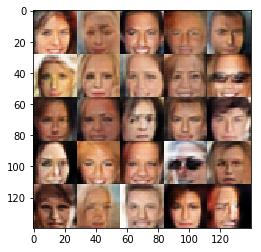

Epoch 2/2... Batch 310... Discriminator Loss: 0.8714... Generator Loss: 1.5180
Epoch 2/2... Batch 320... Discriminator Loss: 1.1968... Generator Loss: 0.7253
Epoch 2/2... Batch 330... Discriminator Loss: 1.1692... Generator Loss: 0.7650
Epoch 2/2... Batch 340... Discriminator Loss: 1.0443... Generator Loss: 1.8955
Epoch 2/2... Batch 350... Discriminator Loss: 1.0134... Generator Loss: 1.8295
Epoch 2/2... Batch 360... Discriminator Loss: 0.9500... Generator Loss: 0.8412
Epoch 2/2... Batch 370... Discriminator Loss: 1.0701... Generator Loss: 0.9919
Epoch 2/2... Batch 380... Discriminator Loss: 0.9660... Generator Loss: 1.2563
Epoch 2/2... Batch 390... Discriminator Loss: 0.8189... Generator Loss: 1.7874
Epoch 2/2... Batch 400... Discriminator Loss: 0.9534... Generator Loss: 1.1683


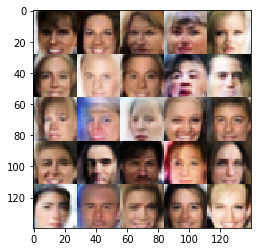

Epoch 2/2... Batch 410... Discriminator Loss: 0.7457... Generator Loss: 1.9608
Epoch 2/2... Batch 420... Discriminator Loss: 0.9047... Generator Loss: 1.0926
Epoch 2/2... Batch 430... Discriminator Loss: 0.7377... Generator Loss: 2.1488
Epoch 2/2... Batch 440... Discriminator Loss: 1.3106... Generator Loss: 0.7032
Epoch 2/2... Batch 450... Discriminator Loss: 0.9433... Generator Loss: 1.3582
Epoch 2/2... Batch 460... Discriminator Loss: 1.1079... Generator Loss: 0.8117
Epoch 2/2... Batch 470... Discriminator Loss: 0.7887... Generator Loss: 1.2419
Epoch 2/2... Batch 480... Discriminator Loss: 0.8615... Generator Loss: 1.7316
Epoch 2/2... Batch 490... Discriminator Loss: 1.2014... Generator Loss: 2.1111
Epoch 2/2... Batch 500... Discriminator Loss: 1.3794... Generator Loss: 0.4963


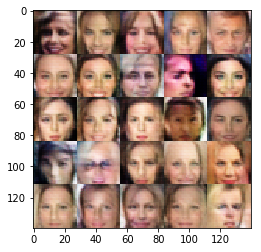

Epoch 2/2... Batch 510... Discriminator Loss: 0.8548... Generator Loss: 1.1701
Epoch 2/2... Batch 520... Discriminator Loss: 0.7428... Generator Loss: 1.4417
Epoch 2/2... Batch 530... Discriminator Loss: 0.9035... Generator Loss: 1.1861
Epoch 2/2... Batch 540... Discriminator Loss: 0.9933... Generator Loss: 0.9407
Epoch 2/2... Batch 550... Discriminator Loss: 1.2232... Generator Loss: 0.6890
Epoch 2/2... Batch 560... Discriminator Loss: 1.0649... Generator Loss: 0.7812
Epoch 2/2... Batch 570... Discriminator Loss: 0.9639... Generator Loss: 1.0862
Epoch 2/2... Batch 580... Discriminator Loss: 0.9476... Generator Loss: 1.0822
Epoch 2/2... Batch 590... Discriminator Loss: 1.1796... Generator Loss: 1.7305
Epoch 2/2... Batch 600... Discriminator Loss: 1.3959... Generator Loss: 2.7919


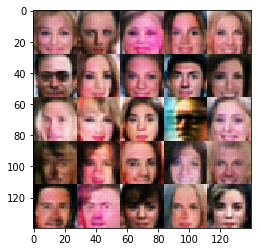

Epoch 2/2... Batch 610... Discriminator Loss: 1.0422... Generator Loss: 0.8637
Epoch 2/2... Batch 620... Discriminator Loss: 0.9297... Generator Loss: 2.4660
Epoch 2/2... Batch 630... Discriminator Loss: 1.1340... Generator Loss: 0.7793
Epoch 2/2... Batch 640... Discriminator Loss: 0.9505... Generator Loss: 1.0758
Epoch 2/2... Batch 650... Discriminator Loss: 0.8345... Generator Loss: 1.5427
Epoch 2/2... Batch 660... Discriminator Loss: 0.7932... Generator Loss: 1.3824
Epoch 2/2... Batch 670... Discriminator Loss: 0.8951... Generator Loss: 1.2652
Epoch 2/2... Batch 680... Discriminator Loss: 0.9971... Generator Loss: 1.1946
Epoch 2/2... Batch 690... Discriminator Loss: 0.9038... Generator Loss: 1.1941
Epoch 2/2... Batch 700... Discriminator Loss: 0.8854... Generator Loss: 1.2582


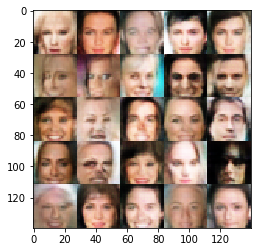

Epoch 2/2... Batch 710... Discriminator Loss: 0.9123... Generator Loss: 2.0958
Epoch 2/2... Batch 720... Discriminator Loss: 0.9652... Generator Loss: 2.0327
Epoch 2/2... Batch 730... Discriminator Loss: 1.4892... Generator Loss: 0.5829
Epoch 2/2... Batch 740... Discriminator Loss: 1.0540... Generator Loss: 0.7890
Epoch 2/2... Batch 750... Discriminator Loss: 1.0420... Generator Loss: 1.0963
Epoch 2/2... Batch 760... Discriminator Loss: 0.7375... Generator Loss: 1.6325
Epoch 2/2... Batch 770... Discriminator Loss: 0.7268... Generator Loss: 1.8485
Epoch 2/2... Batch 780... Discriminator Loss: 1.0456... Generator Loss: 0.7512
Epoch 2/2... Batch 790... Discriminator Loss: 0.9557... Generator Loss: 1.3482
Epoch 2/2... Batch 800... Discriminator Loss: 1.1877... Generator Loss: 0.8063


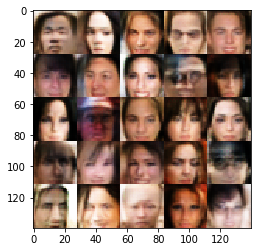

Epoch 2/2... Batch 810... Discriminator Loss: 0.9908... Generator Loss: 1.2419
Epoch 2/2... Batch 820... Discriminator Loss: 0.8262... Generator Loss: 1.5661
Epoch 2/2... Batch 830... Discriminator Loss: 1.0425... Generator Loss: 1.0566
Epoch 2/2... Batch 840... Discriminator Loss: 0.8234... Generator Loss: 1.1881
Epoch 2/2... Batch 850... Discriminator Loss: 0.9102... Generator Loss: 2.0720
Epoch 2/2... Batch 860... Discriminator Loss: 1.1540... Generator Loss: 2.2729
Epoch 2/2... Batch 870... Discriminator Loss: 0.8502... Generator Loss: 1.6369
Epoch 2/2... Batch 880... Discriminator Loss: 0.8497... Generator Loss: 1.2798
Epoch 2/2... Batch 890... Discriminator Loss: 1.0624... Generator Loss: 2.5375
Epoch 2/2... Batch 900... Discriminator Loss: 0.8417... Generator Loss: 1.6690


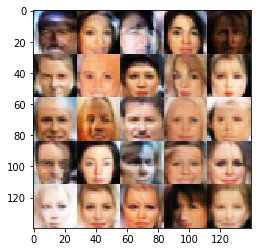

Epoch 2/2... Batch 910... Discriminator Loss: 0.9719... Generator Loss: 0.9895
Epoch 2/2... Batch 920... Discriminator Loss: 1.0382... Generator Loss: 0.8580
Epoch 2/2... Batch 930... Discriminator Loss: 0.7541... Generator Loss: 1.4521
Epoch 2/2... Batch 940... Discriminator Loss: 1.0156... Generator Loss: 0.8282
Epoch 2/2... Batch 950... Discriminator Loss: 1.4367... Generator Loss: 0.6564
Epoch 2/2... Batch 960... Discriminator Loss: 1.0010... Generator Loss: 0.9405
Epoch 2/2... Batch 970... Discriminator Loss: 0.7580... Generator Loss: 2.2217
Epoch 2/2... Batch 980... Discriminator Loss: 0.7750... Generator Loss: 1.3149
Epoch 2/2... Batch 990... Discriminator Loss: 1.1507... Generator Loss: 0.7163
Epoch 2/2... Batch 1000... Discriminator Loss: 1.1646... Generator Loss: 0.8230


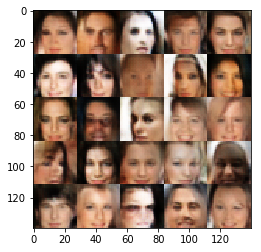

Epoch 2/2... Batch 1010... Discriminator Loss: 1.3166... Generator Loss: 2.2543
Epoch 2/2... Batch 1020... Discriminator Loss: 0.7763... Generator Loss: 1.4444
Epoch 2/2... Batch 1030... Discriminator Loss: 2.1911... Generator Loss: 3.4886
Epoch 2/2... Batch 1040... Discriminator Loss: 1.0224... Generator Loss: 1.1974
Epoch 2/2... Batch 1050... Discriminator Loss: 0.8217... Generator Loss: 1.5408
Epoch 2/2... Batch 1060... Discriminator Loss: 0.8821... Generator Loss: 1.3354
Epoch 2/2... Batch 1070... Discriminator Loss: 1.1204... Generator Loss: 0.6521
Epoch 2/2... Batch 1080... Discriminator Loss: 1.0688... Generator Loss: 2.2998
Epoch 2/2... Batch 1090... Discriminator Loss: 0.8671... Generator Loss: 1.6067
Epoch 2/2... Batch 1100... Discriminator Loss: 1.1168... Generator Loss: 0.8350


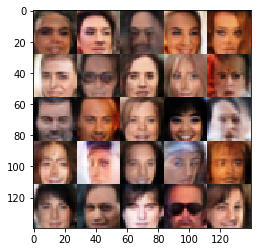

Epoch 2/2... Batch 1110... Discriminator Loss: 2.0457... Generator Loss: 3.6741
Epoch 2/2... Batch 1120... Discriminator Loss: 0.7563... Generator Loss: 1.5352
Epoch 2/2... Batch 1130... Discriminator Loss: 1.1204... Generator Loss: 0.8141
Epoch 2/2... Batch 1140... Discriminator Loss: 1.1704... Generator Loss: 0.8714
Epoch 2/2... Batch 1150... Discriminator Loss: 0.8225... Generator Loss: 1.1926
Epoch 2/2... Batch 1160... Discriminator Loss: 1.1414... Generator Loss: 0.9770
Epoch 2/2... Batch 1170... Discriminator Loss: 0.8877... Generator Loss: 1.1654
Epoch 2/2... Batch 1180... Discriminator Loss: 1.1841... Generator Loss: 0.7183
Epoch 2/2... Batch 1190... Discriminator Loss: 0.8536... Generator Loss: 1.2259
Epoch 2/2... Batch 1200... Discriminator Loss: 1.1704... Generator Loss: 0.7972


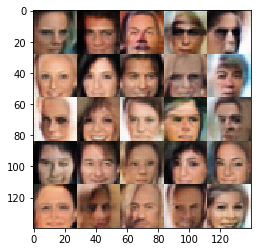

Epoch 2/2... Batch 1210... Discriminator Loss: 0.9567... Generator Loss: 0.9513
Epoch 2/2... Batch 1220... Discriminator Loss: 0.8372... Generator Loss: 1.6005
Epoch 2/2... Batch 1230... Discriminator Loss: 1.4151... Generator Loss: 0.6977
Epoch 2/2... Batch 1240... Discriminator Loss: 0.9131... Generator Loss: 1.3037
Epoch 2/2... Batch 1250... Discriminator Loss: 0.8719... Generator Loss: 2.3350
Epoch 2/2... Batch 1260... Discriminator Loss: 0.9501... Generator Loss: 1.1692
Epoch 2/2... Batch 1270... Discriminator Loss: 1.5476... Generator Loss: 3.1203
Epoch 2/2... Batch 1280... Discriminator Loss: 0.9469... Generator Loss: 1.2398
Epoch 2/2... Batch 1290... Discriminator Loss: 1.2673... Generator Loss: 0.6819
Epoch 2/2... Batch 1300... Discriminator Loss: 1.0952... Generator Loss: 2.4597


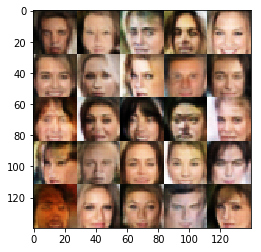

Epoch 2/2... Batch 1310... Discriminator Loss: 0.8281... Generator Loss: 1.1639
Epoch 2/2... Batch 1320... Discriminator Loss: 0.8131... Generator Loss: 1.3257
Epoch 2/2... Batch 1330... Discriminator Loss: 1.6245... Generator Loss: 0.6826
Epoch 2/2... Batch 1340... Discriminator Loss: 2.0194... Generator Loss: 3.0612
Epoch 2/2... Batch 1350... Discriminator Loss: 0.6154... Generator Loss: 2.2216
Epoch 2/2... Batch 1360... Discriminator Loss: 0.7258... Generator Loss: 1.4110
Epoch 2/2... Batch 1370... Discriminator Loss: 0.8528... Generator Loss: 1.2455
Epoch 2/2... Batch 1380... Discriminator Loss: 0.7613... Generator Loss: 1.6622
Epoch 2/2... Batch 1390... Discriminator Loss: 0.7822... Generator Loss: 1.3015
Epoch 2/2... Batch 1400... Discriminator Loss: 0.6642... Generator Loss: 1.6960


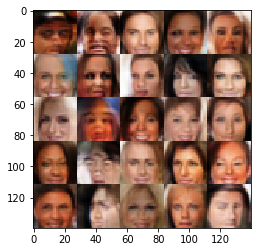

Epoch 2/2... Batch 1410... Discriminator Loss: 0.9284... Generator Loss: 1.0051
Epoch 2/2... Batch 1420... Discriminator Loss: 1.0449... Generator Loss: 1.5613
Epoch 2/2... Batch 1430... Discriminator Loss: 0.8699... Generator Loss: 1.6141
Epoch 2/2... Batch 1440... Discriminator Loss: 0.9612... Generator Loss: 1.1205
Epoch 2/2... Batch 1450... Discriminator Loss: 1.3730... Generator Loss: 3.8549
Epoch 2/2... Batch 1460... Discriminator Loss: 0.7921... Generator Loss: 1.2628
Epoch 2/2... Batch 1470... Discriminator Loss: 0.7965... Generator Loss: 1.9022
Epoch 2/2... Batch 1480... Discriminator Loss: 0.6236... Generator Loss: 1.8704
Epoch 2/2... Batch 1490... Discriminator Loss: 0.7135... Generator Loss: 1.5585
Epoch 2/2... Batch 1500... Discriminator Loss: 0.7579... Generator Loss: 1.6958


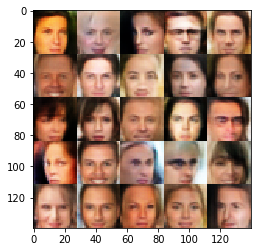

Epoch 2/2... Batch 1510... Discriminator Loss: 0.9458... Generator Loss: 1.1345
Epoch 2/2... Batch 1520... Discriminator Loss: 1.1084... Generator Loss: 0.8934
Epoch 2/2... Batch 1530... Discriminator Loss: 0.8624... Generator Loss: 1.7094
Epoch 2/2... Batch 1540... Discriminator Loss: 0.8064... Generator Loss: 1.9299
Epoch 2/2... Batch 1550... Discriminator Loss: 0.8079... Generator Loss: 2.6888
Epoch 2/2... Batch 1560... Discriminator Loss: 0.8523... Generator Loss: 1.2914
Epoch 2/2... Batch 1570... Discriminator Loss: 0.7393... Generator Loss: 1.6335
Epoch 2/2... Batch 1580... Discriminator Loss: 0.8231... Generator Loss: 1.4342
Epoch 2/2... Batch 1590... Discriminator Loss: 0.9100... Generator Loss: 1.6920
Epoch 2/2... Batch 1600... Discriminator Loss: 1.0609... Generator Loss: 0.7312


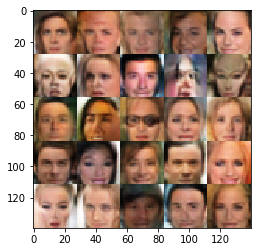

Epoch 2/2... Batch 1610... Discriminator Loss: 1.1185... Generator Loss: 2.7222
Epoch 2/2... Batch 1620... Discriminator Loss: 0.8326... Generator Loss: 1.3090
Epoch 2/2... Batch 1630... Discriminator Loss: 0.9437... Generator Loss: 1.8491
Epoch 2/2... Batch 1640... Discriminator Loss: 0.8727... Generator Loss: 2.8742
Epoch 2/2... Batch 1650... Discriminator Loss: 1.5491... Generator Loss: 0.5451
Epoch 2/2... Batch 1660... Discriminator Loss: 0.7384... Generator Loss: 1.4262
Epoch 2/2... Batch 1670... Discriminator Loss: 0.8513... Generator Loss: 1.0300
Epoch 2/2... Batch 1680... Discriminator Loss: 0.8845... Generator Loss: 1.3250
Epoch 2/2... Batch 1690... Discriminator Loss: 1.0275... Generator Loss: 2.2737
Epoch 2/2... Batch 1700... Discriminator Loss: 1.5223... Generator Loss: 0.5527


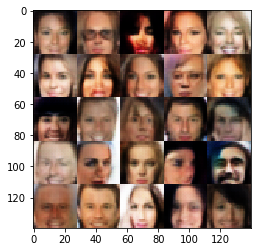

Epoch 2/2... Batch 1710... Discriminator Loss: 0.9532... Generator Loss: 1.1105
Epoch 2/2... Batch 1720... Discriminator Loss: 0.7810... Generator Loss: 1.7905
Epoch 2/2... Batch 1730... Discriminator Loss: 0.9373... Generator Loss: 0.9859
Epoch 2/2... Batch 1740... Discriminator Loss: 0.7959... Generator Loss: 1.9218
Epoch 2/2... Batch 1750... Discriminator Loss: 1.3333... Generator Loss: 0.7140
Epoch 2/2... Batch 1760... Discriminator Loss: 0.7887... Generator Loss: 1.4533
Epoch 2/2... Batch 1770... Discriminator Loss: 1.3580... Generator Loss: 0.6692
Epoch 2/2... Batch 1780... Discriminator Loss: 1.0580... Generator Loss: 0.8125
Epoch 2/2... Batch 1790... Discriminator Loss: 1.0997... Generator Loss: 0.9469
Epoch 2/2... Batch 1800... Discriminator Loss: 1.0135... Generator Loss: 0.7552


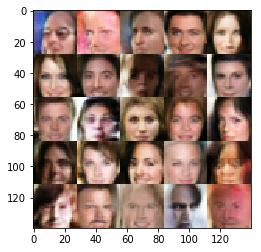

Epoch 2/2... Batch 1810... Discriminator Loss: 0.7422... Generator Loss: 1.7248
Epoch 2/2... Batch 1820... Discriminator Loss: 0.7315... Generator Loss: 1.5142
Epoch 2/2... Batch 1830... Discriminator Loss: 0.9981... Generator Loss: 1.8600
Epoch 2/2... Batch 1840... Discriminator Loss: 0.9080... Generator Loss: 0.9296
Epoch 2/2... Batch 1850... Discriminator Loss: 0.8560... Generator Loss: 2.0038
Epoch 2/2... Batch 1860... Discriminator Loss: 1.4673... Generator Loss: 0.6246
Epoch 2/2... Batch 1870... Discriminator Loss: 0.7830... Generator Loss: 1.3193
Epoch 2/2... Batch 1880... Discriminator Loss: 0.7388... Generator Loss: 1.5625
Epoch 2/2... Batch 1890... Discriminator Loss: 0.8525... Generator Loss: 2.4131
Epoch 2/2... Batch 1900... Discriminator Loss: 0.7248... Generator Loss: 1.5731


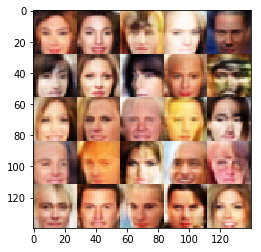

Epoch 2/2... Batch 1910... Discriminator Loss: 0.7866... Generator Loss: 1.3437
Epoch 2/2... Batch 1920... Discriminator Loss: 1.3643... Generator Loss: 0.6301
Epoch 2/2... Batch 1930... Discriminator Loss: 0.7756... Generator Loss: 1.3790
Epoch 2/2... Batch 1940... Discriminator Loss: 1.2094... Generator Loss: 0.8610
Epoch 2/2... Batch 1950... Discriminator Loss: 0.5544... Generator Loss: 2.2338
Epoch 2/2... Batch 1960... Discriminator Loss: 0.8475... Generator Loss: 2.9644
Epoch 2/2... Batch 1970... Discriminator Loss: 1.0465... Generator Loss: 0.9652
Epoch 2/2... Batch 1980... Discriminator Loss: 0.6195... Generator Loss: 2.3574
Epoch 2/2... Batch 1990... Discriminator Loss: 1.3638... Generator Loss: 0.6047
Epoch 2/2... Batch 2000... Discriminator Loss: 0.8403... Generator Loss: 1.4277


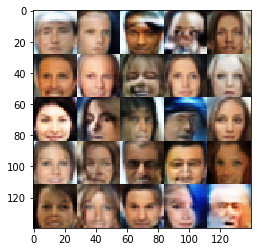

Epoch 2/2... Batch 2010... Discriminator Loss: 0.6466... Generator Loss: 2.5757
Epoch 2/2... Batch 2020... Discriminator Loss: 0.7272... Generator Loss: 1.5262
Epoch 2/2... Batch 2030... Discriminator Loss: 0.6986... Generator Loss: 1.7100
Epoch 2/2... Batch 2040... Discriminator Loss: 0.9860... Generator Loss: 3.2560
Epoch 2/2... Batch 2050... Discriminator Loss: 0.7194... Generator Loss: 1.3077
Epoch 2/2... Batch 2060... Discriminator Loss: 1.9910... Generator Loss: 3.9165
Epoch 2/2... Batch 2070... Discriminator Loss: 0.6970... Generator Loss: 2.1877
Epoch 2/2... Batch 2080... Discriminator Loss: 0.7308... Generator Loss: 1.6172
Epoch 2/2... Batch 2090... Discriminator Loss: 0.7516... Generator Loss: 1.8766
Epoch 2/2... Batch 2100... Discriminator Loss: 0.6352... Generator Loss: 1.6678


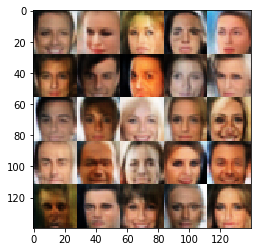

Epoch 2/2... Batch 2110... Discriminator Loss: 0.8648... Generator Loss: 2.6571
Epoch 2/2... Batch 2120... Discriminator Loss: 1.5135... Generator Loss: 0.6319
Epoch 2/2... Batch 2130... Discriminator Loss: 0.6511... Generator Loss: 1.9531
Epoch 2/2... Batch 2140... Discriminator Loss: 0.9208... Generator Loss: 1.2507
Epoch 2/2... Batch 2150... Discriminator Loss: 0.7743... Generator Loss: 1.2077
Epoch 2/2... Batch 2160... Discriminator Loss: 0.6531... Generator Loss: 1.7803
Epoch 2/2... Batch 2170... Discriminator Loss: 0.5564... Generator Loss: 2.2419
Epoch 2/2... Batch 2180... Discriminator Loss: 0.8096... Generator Loss: 2.1586
Epoch 2/2... Batch 2190... Discriminator Loss: 1.1091... Generator Loss: 3.2346
Epoch 2/2... Batch 2200... Discriminator Loss: 0.7023... Generator Loss: 2.0213


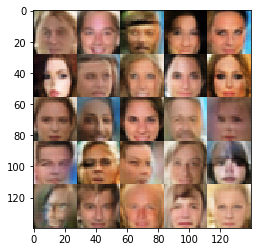

Epoch 2/2... Batch 2210... Discriminator Loss: 0.6257... Generator Loss: 2.0122
Epoch 2/2... Batch 2220... Discriminator Loss: 0.8679... Generator Loss: 1.0906
Epoch 2/2... Batch 2230... Discriminator Loss: 1.0088... Generator Loss: 0.8167
Epoch 2/2... Batch 2240... Discriminator Loss: 0.7013... Generator Loss: 1.7342
Epoch 2/2... Batch 2250... Discriminator Loss: 0.7205... Generator Loss: 2.0050
Epoch 2/2... Batch 2260... Discriminator Loss: 1.0762... Generator Loss: 0.9125
Epoch 2/2... Batch 2270... Discriminator Loss: 1.3608... Generator Loss: 0.7631
Epoch 2/2... Batch 2280... Discriminator Loss: 0.6728... Generator Loss: 1.6606
Epoch 2/2... Batch 2290... Discriminator Loss: 0.9113... Generator Loss: 1.2813
Epoch 2/2... Batch 2300... Discriminator Loss: 0.8525... Generator Loss: 1.3128


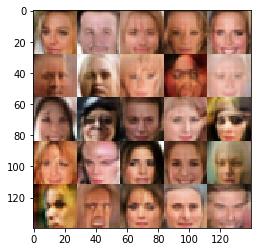

Epoch 2/2... Batch 2310... Discriminator Loss: 0.9970... Generator Loss: 2.7153
Epoch 2/2... Batch 2320... Discriminator Loss: 0.8687... Generator Loss: 1.4001
Epoch 2/2... Batch 2330... Discriminator Loss: 0.7991... Generator Loss: 2.5705
Epoch 2/2... Batch 2340... Discriminator Loss: 0.8102... Generator Loss: 1.6800
Epoch 2/2... Batch 2350... Discriminator Loss: 0.6590... Generator Loss: 1.7858
Epoch 2/2... Batch 2360... Discriminator Loss: 0.8501... Generator Loss: 1.2160
Epoch 2/2... Batch 2370... Discriminator Loss: 0.8302... Generator Loss: 1.8305
Epoch 2/2... Batch 2380... Discriminator Loss: 0.7617... Generator Loss: 1.2718
Epoch 2/2... Batch 2390... Discriminator Loss: 0.7951... Generator Loss: 1.2261
Epoch 2/2... Batch 2400... Discriminator Loss: 1.2265... Generator Loss: 0.6243


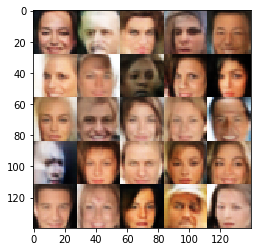

Epoch 2/2... Batch 2410... Discriminator Loss: 0.6437... Generator Loss: 2.1481
Epoch 2/2... Batch 2420... Discriminator Loss: 0.5766... Generator Loss: 2.1607
Epoch 2/2... Batch 2430... Discriminator Loss: 0.5234... Generator Loss: 2.3791
Epoch 2/2... Batch 2440... Discriminator Loss: 1.2001... Generator Loss: 3.2572
Epoch 2/2... Batch 2450... Discriminator Loss: 0.7804... Generator Loss: 1.5498
Epoch 2/2... Batch 2460... Discriminator Loss: 1.0346... Generator Loss: 0.8615
Epoch 2/2... Batch 2470... Discriminator Loss: 0.6729... Generator Loss: 2.3172
Epoch 2/2... Batch 2480... Discriminator Loss: 0.6758... Generator Loss: 2.0374
Epoch 2/2... Batch 2490... Discriminator Loss: 0.7441... Generator Loss: 2.7369
Epoch 2/2... Batch 2500... Discriminator Loss: 0.7680... Generator Loss: 1.9931


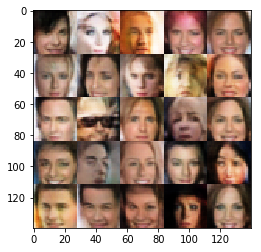

Epoch 2/2... Batch 2510... Discriminator Loss: 0.6716... Generator Loss: 1.4355
Epoch 2/2... Batch 2520... Discriminator Loss: 0.6038... Generator Loss: 2.4699
Epoch 2/2... Batch 2530... Discriminator Loss: 1.1396... Generator Loss: 0.8243
Epoch 2/2... Batch 2540... Discriminator Loss: 0.8296... Generator Loss: 1.2770
Epoch 2/2... Batch 2550... Discriminator Loss: 0.7116... Generator Loss: 1.4692
Epoch 2/2... Batch 2560... Discriminator Loss: 1.4660... Generator Loss: 0.4533
Epoch 2/2... Batch 2570... Discriminator Loss: 1.0073... Generator Loss: 1.0217
Epoch 2/2... Batch 2580... Discriminator Loss: 0.7252... Generator Loss: 1.8717
Epoch 2/2... Batch 2590... Discriminator Loss: 1.0363... Generator Loss: 0.8785
Epoch 2/2... Batch 2600... Discriminator Loss: 0.7046... Generator Loss: 1.8827


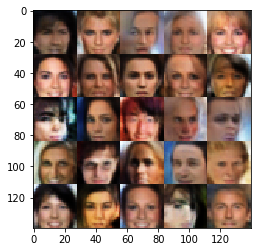

Epoch 2/2... Batch 2610... Discriminator Loss: 0.8080... Generator Loss: 1.5271
Epoch 2/2... Batch 2620... Discriminator Loss: 0.8075... Generator Loss: 1.3628
Epoch 2/2... Batch 2630... Discriminator Loss: 0.8522... Generator Loss: 1.5132
Epoch 2/2... Batch 2640... Discriminator Loss: 0.6834... Generator Loss: 3.2737
Epoch 2/2... Batch 2650... Discriminator Loss: 1.1934... Generator Loss: 0.6699
Epoch 2/2... Batch 2660... Discriminator Loss: 0.8233... Generator Loss: 1.3190
Epoch 2/2... Batch 2670... Discriminator Loss: 0.7109... Generator Loss: 1.7512
Epoch 2/2... Batch 2680... Discriminator Loss: 0.6881... Generator Loss: 2.0659
Epoch 2/2... Batch 2690... Discriminator Loss: 0.7826... Generator Loss: 1.1590
Epoch 2/2... Batch 2700... Discriminator Loss: 0.9440... Generator Loss: 1.0085


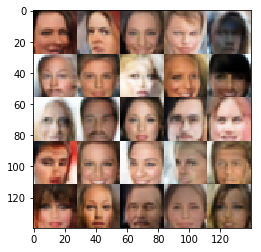

Epoch 2/2... Batch 2710... Discriminator Loss: 0.7523... Generator Loss: 1.4683
Epoch 2/2... Batch 2720... Discriminator Loss: 0.7861... Generator Loss: 3.2055
Epoch 2/2... Batch 2730... Discriminator Loss: 0.7818... Generator Loss: 1.3681
Epoch 2/2... Batch 2740... Discriminator Loss: 0.7216... Generator Loss: 2.3957
Epoch 2/2... Batch 2750... Discriminator Loss: 0.7845... Generator Loss: 2.5401
Epoch 2/2... Batch 2760... Discriminator Loss: 1.0372... Generator Loss: 0.8940
Epoch 2/2... Batch 2770... Discriminator Loss: 0.7156... Generator Loss: 1.8975
Epoch 2/2... Batch 2780... Discriminator Loss: 0.8629... Generator Loss: 2.6087
Epoch 2/2... Batch 2790... Discriminator Loss: 0.8852... Generator Loss: 1.1512
Epoch 2/2... Batch 2800... Discriminator Loss: 0.7041... Generator Loss: 1.6440


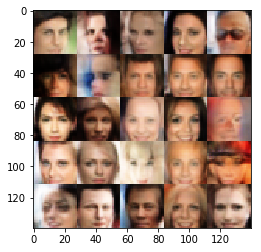

Epoch 2/2... Batch 2810... Discriminator Loss: 1.8094... Generator Loss: 0.4288
Epoch 2/2... Batch 2820... Discriminator Loss: 0.6757... Generator Loss: 2.2140
Epoch 2/2... Batch 2830... Discriminator Loss: 0.6482... Generator Loss: 2.0390
Epoch 2/2... Batch 2840... Discriminator Loss: 0.5426... Generator Loss: 2.2215
Epoch 2/2... Batch 2850... Discriminator Loss: 0.6852... Generator Loss: 3.0088
Epoch 2/2... Batch 2860... Discriminator Loss: 0.7273... Generator Loss: 1.5572
Epoch 2/2... Batch 2870... Discriminator Loss: 0.7132... Generator Loss: 1.6842
Epoch 2/2... Batch 2880... Discriminator Loss: 0.5762... Generator Loss: 3.2371
Epoch 2/2... Batch 2890... Discriminator Loss: 0.5828... Generator Loss: 2.0334
Epoch 2/2... Batch 2900... Discriminator Loss: 1.0255... Generator Loss: 0.9379


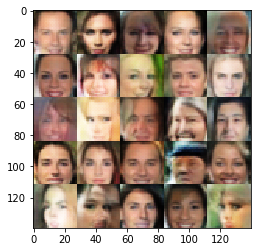

Epoch 2/2... Batch 2910... Discriminator Loss: 0.6927... Generator Loss: 1.3157
Epoch 2/2... Batch 2920... Discriminator Loss: 0.6048... Generator Loss: 2.3110
Epoch 2/2... Batch 2930... Discriminator Loss: 1.0035... Generator Loss: 0.9034
Epoch 2/2... Batch 2940... Discriminator Loss: 0.7074... Generator Loss: 1.7015
Epoch 2/2... Batch 2950... Discriminator Loss: 0.6592... Generator Loss: 1.7827
Epoch 2/2... Batch 2960... Discriminator Loss: 0.4950... Generator Loss: 2.8999
Epoch 2/2... Batch 2970... Discriminator Loss: 0.7714... Generator Loss: 2.4033
Epoch 2/2... Batch 2980... Discriminator Loss: 0.6973... Generator Loss: 1.9720
Epoch 2/2... Batch 2990... Discriminator Loss: 1.0545... Generator Loss: 0.7551
Epoch 2/2... Batch 3000... Discriminator Loss: 0.5944... Generator Loss: 2.1490


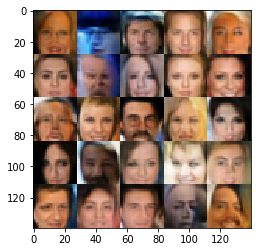

Epoch 2/2... Batch 3010... Discriminator Loss: 0.5731... Generator Loss: 2.2186
Epoch 2/2... Batch 3020... Discriminator Loss: 0.6919... Generator Loss: 2.3787
Epoch 2/2... Batch 3030... Discriminator Loss: 0.7878... Generator Loss: 1.6738
Epoch 2/2... Batch 3040... Discriminator Loss: 0.7137... Generator Loss: 1.5216
Epoch 2/2... Batch 3050... Discriminator Loss: 0.5947... Generator Loss: 2.2647
Epoch 2/2... Batch 3060... Discriminator Loss: 0.5219... Generator Loss: 3.7187
Epoch 2/2... Batch 3070... Discriminator Loss: 0.7684... Generator Loss: 1.2556
Epoch 2/2... Batch 3080... Discriminator Loss: 1.0569... Generator Loss: 3.2711
Epoch 2/2... Batch 3090... Discriminator Loss: 0.6425... Generator Loss: 1.8666
Epoch 2/2... Batch 3100... Discriminator Loss: 0.5772... Generator Loss: 1.9960


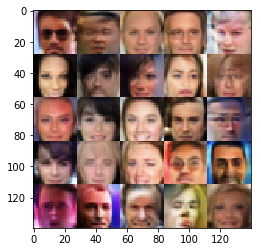

Epoch 2/2... Batch 3110... Discriminator Loss: 0.6324... Generator Loss: 2.6148
Epoch 2/2... Batch 3120... Discriminator Loss: 0.6017... Generator Loss: 2.0576
Epoch 2/2... Batch 3130... Discriminator Loss: 0.6655... Generator Loss: 1.6581
Epoch 2/2... Batch 3140... Discriminator Loss: 0.8662... Generator Loss: 1.0042
Epoch 2/2... Batch 3150... Discriminator Loss: 0.6374... Generator Loss: 1.5946
Epoch 2/2... Batch 3160... Discriminator Loss: 0.5985... Generator Loss: 2.4023


In [16]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.